# Publishing script

## 1. Import required libraries

In [1]:
import sys
import json
import copy
import os
import csv
import fnmatch
import getpass
import re

import requests
from arcgis.gis import GIS

## 2. Set up the global information and variables

In [2]:
global open_data_group         # ArcGIS group with which the data will be shared
global failed_series           # Variable to keep track of any csv file that cannot be staged
global online_username         # ArcGIS credentials
global gis_online_connection   # ArcGIS connection
global layer_json_data         # Information pertaining to the layer template
global user_items              # Collection of items owned by user

#### Initialize failed_series array

In [3]:
failed_series = []

## 3. User parameters:

In [4]:
property_update_only = False
update_symbology = True
update_sharing = True

release = '2019.Q2.G.01' # Make sure to have the correct release here

# https://volderette.de/jupyter-notebook-tip-multiple-outputs/
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#### Set path to data and metadata directories in the local branch: 

In [5]:
dir_path = os.path.dirname(os.path.realpath('__file__'))
print(dir_path)

data_dir = r'../../data/unsd/' + release + '/'
metadata_dir = r"../../globalResources/"


print('data inputs dir: ' + data_dir)

C:\Users\L.GonzalezMorales\Documents\GitHub\FIS4SDGs\notebooks\unsdPublishing
data inputs dir: ../../data/unsd/2019.Q2.G.01/


## 4. Utilities

### 4.1 - Get metadata

In [6]:

def get_series_metadata(file, print_first_element = True):    
    
    """ Get json metadata file """
    
    try:
        series_metadata = json.load(open(file))
        if(print_first_element==True):
            print("\n----This is an example of a series_metadata element----")
            print(series_metadata[0])
        return series_metadata
    
    except:
        print("Unexpected error:", sys.exc_info()[0])
        return None
    

### 4.2 - Get file catalog

In [7]:
def get_file_catalog (dir_path, pattern = '*'):
    
    """ Create a list of files in a folder """

    try:
        files = list()

        listOfFiles = os.listdir(dir_path)  
        for entry in listOfFiles:  
            if fnmatch.fnmatch(entry, pattern):
                files.append(entry)
        return files
            
    except:
        print("Unexpected error:", sys.exc_info()[0]) 
        return None
        

### 4.3 - Read csv to list

In [8]:
def read_csv_to_list (file, encoding="utf8", delimiter='\t'):
    
    """ Read a csv file into a list """

    try:
        
        with open(file, encoding=encoding) as f:
            reader = csv.reader(f, delimiter=delimiter)
            data = list(reader)
        return data
            
    except:
        print("Unexpected error:", sys.exc_info()[0]) 
        return None

### 4.4 - Read csv to dict

In [9]:
def read_csv_to_dict (file, encoding="utf8", delimiter='\t'):
    
    """ Read a csv file into a dict """

    try:
   
        with open(file,  encoding=encoding) as f:
            reader = csv.DictReader(f, delimiter= delimiter)
            dict_list = list()
            for line in reader:
                dict_list.append(dict(line))
            return dict_list
    
    except:
        print("Unexpected error:", sys.exc_info()[0]) 
        return None
    


## 4.5 Split camelCase

In [10]:
def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    x = ' '.join([m.group(0) for m in matches])
    return x

## 4.6 Compute a hash of a dictionary

In [11]:
def dict_hash(d):
    out = hashlib.md5()
    for key, value in d.items():
        out.update(key.encode('utf-8'))
        out.update(value.encode('utf-8'))
    return out.hexdigest()


## 4.7 Get unique dictionaries in a list

In [12]:
def unique_dicts(dictionary_list):

    uniques_map = {}

    for d in dictionary_list:
        uniques_map[dict_hash(d)] = d

    return list(uniques_map.values())


## 4.8 Extract subset of key-value pairs from Python dictionary object

In [13]:
def subdict_list(dict_list, keys_list, exclude = False):
    sub_d_list = []
    if exclude:
        for d in dict_list:
            sub_d= {k: d[k] for k in d.keys() if k not in keys_list}
            sub_d_list.append(sub_d)
    else:
        for d in dict_list:
            sub_d= {k: d[k] for k in keys_list}
            sub_d_list.append(sub_d)
    
    return sub_d_list




## 4.9 Get a dict from a list based on something inside the dict

In [14]:
def select_dict(dict_list, k, v):
    selected = []
    for d in dict_list:
        if d[k] == v:
            selected.append(d)
    return selected

# 5 - ArcGIS API modules

## 5.1 - Open connection to ArcGIS Online Organization

In [15]:
def connect_to_arcGIS():

    """Open connection to ArcGIS Online Organization"""
        
    online_username = input('Username: ')
    online_password = getpass.getpass('Password: ')
    online_connection = "https://www.arcgis.com"
    gis_online_connection = GIS(online_connection, 
                                online_username, 
                                online_password)
    
    return online_username, gis_online_connection

## 5.2 - Explore existing open data gruop

In [16]:
def open_data_group(gis_online_connection,id):
    
    open_data_group = gis_online_connection.groups.get(id)
    return (open_data_group)
   

## 5.3 - Cleanup staging folder

In [17]:
def cleanup_staging_folder(user_items):

    """ Cleanup staging folder for Open Data (delete everything in the staging folder for Open Data)"""
    
    if input('Do you want to cleanup your staging folder for Open Data? (y/n)') == 'y':
        if input('Are you sure? (y/n)') == 'y':
            for item in user_items:
                print('deleting item ' + item.title)
                item.delete()
        else: print('Cleanup of staging forlder for Open Data was canceled') 
    else:
        print('Cleanup of staging forlder for Open Data was canceled')      
        

## 5.4 - Get layer info template

In [18]:
def get_layer_info_template(file, print_first_element = True):  
    
    """ Get layer info template """
    
    try:
        layer_info_template = json.load(open(file))
        if(print_first_element==True):
            print("/n----This is the layer info template ----")
            print(layer_info_template)
        return layer_info_template
    except:
        print("Unexpected error:", sys.exc_info()[0]) 
        return None
        

## 5.5 - Build series metadata card

In [19]:
def build_series_card(g,t,i,s):
    """ Build series metadata card """
    
    try:
        s_card = dict()
        title = 'Indicator ' + i['reference'] + ': ' + s['description'].replace('%','percent')
        s_card['title'] = (title[:250] + '..') if len(title) > 250 else title
        s_card['layer_title'] = s['description'].replace('%','percent').replace(',',' ').replace('/',' ')
        
        s_card['snippet'] = s_card['title']
        
        #s_card['snippet'] = (snippet[:250] + '..') if len(snippet) > 250 else snippet
        s_card['description'] =  \
                    '<div style="background-color: #'+ g['hex'] +'; color:#fff; padding: 15px">' + \
                    '<ul style="list-style: none;">' + \
                    '<li><strong> Series Name:</strong> ' + s['description'].replace(',',' ').replace('/',' ') + '</li>' + \
                    '<li><strong>Series Code:</strong> ' + s['code'] + '</li>' + \
                    '<li><strong>Release Version:</strong> ' + s['release'] + '</li>'+ \
                    '</ul>' + \
                    '</div>' + \
                    '<div style="background-color: #f4f4f4; padding: 15px">' + \
                    '<p> This dataset is the part of the Global SDG Indicator Database compiled ' + \
                    'through the UN System in preparation for the Secretary-General\'s annual report on <em>Progress towards the Sustainable Development Goals</em>.' + \
                    '</p>' + \
                    '<p><strong>Indicator ' + i['reference'] + ': </strong>' + i['descEN'] + \
                    '</p>' + \
                    '<p><strong>Target ' + t['code'] + ': </strong>' + t['descEN'] + \
                    '</p>' + \
                    '<p><strong>Goal ' + g['code'] + ': </strong>' + g['descEN'] + \
                    '</p>' +  \
                    '<p><em>For more information on the compilation methodology of this dataset, ' +\
                    ' see <a href="https://unstats.un.org/sdgs/metadata/" target="_blank">https://unstats.un.org/sdgs/metadata/' + \
                    '</a></em></p>'+ \
                    '</div>' 
        
        series_tags = s['tags'][:]
        series_tags.append(s['release'])
                
        s_card['tags'] = series_tags
        
        return s_card
    except:
        print('Unexpected error:', sys.exc_info()[0]) 
        return None
        

## 5.6 - Find online item

In [20]:
def find_online_item(title, owner, gis_online_connection, force_find=True):
        
    try:

        # Search for this ArcGIS Online Item
        query_string = "title:'{}' AND owner:{}".format(title, owner)
        print('Searching for ' + title)
        # The search() method returns a list of Item objects that match the 
        # search criteria
        search_results = gis_online_connection.content.search(query_string)
        
        if search_results:
            for item in search_results:
                if item['title'] == title:
                    print(' -- Item ' + title + ' found (simple find)')
                    return item
        
        if force_find:
            user = gis_online_connection.users.get(owner)
            user_items = user.items(folder='Open Data', max_items=800)
            for item in user_items:
                if item['title'] == title:
                    print(' -- Item ' + title + ' found (force find)')
                    return item
            print(' -- Item ' + title + ' not found (force find)')
            return None
        
        print(' -- Item ' + title + ' not found (simple find)')
        return None
    
    except:
        print('Unexpected error:', sys.exc_info()[0])
        return None

## 5.7 - Generate renderer information

In [21]:
def generate_renderer_infomation(feature_item, 
                                 statistic_field,
                                 layer_info,
                                 color=None):
    try:
        if len(color) == 3:
            color.append(130)  ###---specifies the alpha channel of the color
        
        visual_params = layer_info['layerInfo']
        definition_item = feature_item.layers[0]

        #get the min/max values
        out_statistics= [{'statisticType': 'max',
                          'onStatisticField': statistic_field, 
                          'outStatisticFieldName': statistic_field + '_max'},
                        {'statisticType': 'min',
                         'onStatisticField': statistic_field, 
                         'outStatisticFieldName': statistic_field + '_min'}]
        
        feature_set = definition_item.query(where='1=1',out_statistics=out_statistics)

        max_value = feature_set.features[0].attributes[statistic_field + '_max']
        min_value = feature_set.features[0].attributes[statistic_field + '_min']
        
        visual_params['drawingInfo']['renderer']['visualVariables'][0]['minDataValue'] = min_value
        visual_params['drawingInfo']['renderer']['visualVariables'][0]['maxDataValue'] = max_value

        visual_params['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['minSliderValue'] = min_value
        visual_params['drawingInfo']['renderer']['authoringInfo']['visualVariables'][0]['maxSliderValue'] = max_value
        
        visual_params['drawingInfo']['renderer']['classBreakInfos'][0]['symbol']['color'] = color
        visual_params['drawingInfo']['renderer']['transparency'] = 25

        definition_update_params = definition_item.properties
        definition_update_params['drawingInfo']['renderer'] = visual_params['drawingInfo']['renderer']
        if 'editingInfo' in definition_update_params:
            del definition_update_params['editingInfo']
        definition_update_params['capabilities'] = 'Query, Extract, Sync'
        print('Update Feature Service Symbology')
        definition_item.manager.update_definition(definition_update_params)

        return
    except:
        print('Unexpected error in generate_renderer_infomation:', sys.exc_info()[0])
        return None


## 5.8 - Publish csv

In [42]:
def publish_csv(g,t,i,s, 
                item_properties, 
                thumbnail,
                layer_info,
                gis_online_connection, 
                data_dir,
                online_username,
                statistic_field = 'value_latest_year',
                property_update_only=False, 
                color=[169,169,169]):

    
    # Check if service name is available; if not, update the link
    service_title = s['code'] + '_' + i['reference'].replace('.','_') + '_' + s['release'].replace('.', '')
    
    #display(service_title)
    
    service_title_num = 1

    while not gis_online_connection.content.is_service_name_available(service_name= service_title, 
                                                                      service_type = 'featureService'):
        service_title = s['code'] + '_' + i['reference'].replace('.','_') + '_' + s['release'].replace('.', '') + \
          '_' + str(service_title_num)
        service_title_num += 1

    #display(service_title_num)
    
    # csv file to be uploaded:
    file = os.path.join(data_dir, 'csv_Indicator_' + i['reference'] + '_Series_' + s['code'] + '.csv' )
    
    display(file)

    if os.path.isfile(file):
        csv_item_properties = copy.deepcopy(item_properties)
        csv_item_properties['name'] = service_title
        csv_item_properties['title'] = service_title
        csv_item_properties['type'] = 'CSV'
        csv_item_properties['url'] = ''
        
        #display(csv_item_properties)

        # Does this CSV already exist
        csv_item = find_online_item(csv_item_properties['title'],online_username,gis_online_connection)
        
        if csv_item is None:
            print('Adding CSV File to ArcGIS Online....')
            
            #display(gis_online_connection)
            #display(thumbnail)
            
            
            csv_item = gis_online_connection.content.add(item_properties=csv_item_properties, 
                                                         thumbnail=thumbnail,
                                                         data=file)
            
            
            
            if csv_item is None:
                return None

            print('Analyze Feature Service....')
            publish_parameters = analyze_csv(csv_item['id'],gis_online_connection)
            if publish_parameters is None:
                return None
            else:
                publish_parameters['name'] = csv_item_properties['title']
                publish_parameters['layerInfo']['name'] = csv_item_properties['layer_title']
                print('Publishing Feature Service....')
                csv_lyr = csv_item.publish(publish_parameters=publish_parameters, overwrite=True)

                # Update the layer infomation with a basic rendering based on the Latest Value
                # use the hex color from the SDG Metadata for the symbol color

                print('.......call generate renderer within publish_csv')
                generate_renderer_infomation(feature_item=csv_lyr,
                                             statistic_field = statistic_field,
                                             layer_info = layer_info,
                                             color=color) 
                
                
        else:
            # Update the Data file for the CSV File
            csv_item.update(item_properties=csv_item_properties, thumbnail=thumbnail, data=file)
            # Find the Feature Service and update the properties
            csv_lyr = find_online_item(csv_item_properties['title'],online_username,gis_online_connection)

        # Move to the Open Data Folder
        if csv_item['ownerFolder'] is None:
            print('Moving CSV to Open Data Folder')
            csv_item.move('Open Data SDG' + g['code'].zfill(2))

        if csv_lyr is not None:
            print('Updating Feature Service metadata....')
            csv_lyr.update(item_properties=item_properties, thumbnail=thumbnail)

            if csv_lyr['ownerFolder'] is None:
                print('Moving Feature Service to Open Data Folder')
                csv_lyr.move('Open Data SDG' + g['code'].zfill(2))

            return csv_lyr
        else:
            return None
    else:
        return None

## 5.9 - Analyze csv

In [48]:
def analyze_csv(item_id, gis_online_connection):
    try:
        sharing_url = gis_online_connection._url + '/sharing/rest/content/features/analyze'
        analyze_params = {'f': 'json', 
                          'token': gis_online_connection._con.token,
                          'sourceLocale': 'en-us',
                          'filetype': 'csv', 
                          'itemid': item_id}
        r = requests.post(sharing_url, data=analyze_params)
        analyze_json_data = json.loads(r.content.decode('UTF-8'))
        for field in analyze_json_data['publishParameters']['layerInfo']['fields']:
            field['alias'] = set_field_alias(field['name'])
            
            #display(field['name'])
            #display(field['type'])
            #display(field['sqlType'])
            #print('---')

            # IndicatorCode is coming in as a date Field make the correct
            if field['name'] == 'indicator':
                field['type'] = 'esriFieldTypeString'
                field['sqlType'] = 'sqlTypeNVarchar'
            
            if field['name'] == 'target':
                field['type'] = 'esriFieldTypeString'
                field['sqlType'] = 'sqlTypeNVarchar'
                
            if field['name'] == 'latest_year':
                field['type'] = 'esriFieldTypeInteger'
                field['sqlType'] = 'sqlTypeInt'
            
            if  field['name'] == 'valueDetails':
                field['type'] = 'esriFieldTypeString'
                field['sqlType'] = 'sqlTypeNVarchar'
            elif field['name'].startswith( 'value' ):
                field['type'] = 'esriFieldTypeDouble'
                field['sqlType'] = 'sqlTypeFloat'
                
        # set up some of the layer information for display
        analyze_json_data['publishParameters']['layerInfo']['displayField'] = 'geoAreaName'
        return analyze_json_data['publishParameters']
    except:
        print('Unexpected error:', sys.exc_info()[0])
        return None

## 5.10 Set field alias

In [49]:
def set_field_alias(field_name):
    if field_name == 'release':
        return 'Series Release'
    if field_name == 'seriesCode':
        return 'Series Code'
    if field_name == 'seriesDesc':
        return 'Series Description'
    if field_name == 'release':
        return 'Series Release'
    if field_name == 'unitsCode':
        return 'Units Code'
    if field_name == 'unitsDesc':
        return 'Units Description'
    if field_name == 'unitmultiplierCode':
        return 'Unit Multiplier Code'
    if field_name == 'unitmultiplierDesc':
        return 'Unit Multiplier Description'
    if field_name == 'reportingTypeCode':
        return 'Reporting Type Code'
    if field_name == 'reportingTypeDesc':
        return 'Reporting Type Description'
    if field_name == 'geoAreaCode':
        return 'Geographic Area Code'
    if field_name == 'geoAreaName':
        return 'Geographic Area Name'
    if field_name == 'latest_year':
        return 'Latest Year'
    if field_name == 'value_latest_year':
        return 'Value Latest Year'
    if field_name == 'valueDetails':
        return 'Value Details'
    if field_name == 'ISO3':
        return 'ISO Code'
    if field_name == 'goal':
        return 'Goal'
    if field_name == 'target':
        return 'Target'
    if field_name == 'indicator':
        return 'Indicator'
    if field_name == 'timeDetails':
        return 'Time Details'
    if field_name == 'parentCode':
        return 'Parent Area Code'
    if field_name == 'parentName':
        return 'Parent Area Name'
    if field_name == 'type':
        return 'Geogroaphic Area Type'
    if field_name == 'UN_Member':
        return 'UN Member'
    else:
        return camel_case_split(field_name.replace('_', ' ')).replace(' Desc', ' Description').title()
    
    

## 5.11 - Update item categories

In [50]:
def update_item_categories(item, goal, target,gis_online_connection):
    update_url = gis_online_connection._url + "/sharing/rest/content/updateItems"
    items = [{item["id"]:{"categories":["/Categories/Goal " + str(goal) + "/Target " + str(target)]}}]
    update_params = {'f': 'json', 
                         'token': gis_online_connection._con.token, 
                         'items': json.dumps(items)}
    r = requests.post(update_url, data=update_params)
    update_json_data = json.loads(r.content.decode("UTF-8"))
    print(update_json_data)

---
# 6. Main publication script
---

## 6.1 Establish connections to ArcGIS

#### Get ArcGIS connection:

In [26]:
online_username, gis_online_connection = connect_to_arcGIS()

Username:  gonzalezmorales_undesa
Password:  ··········


In [27]:
gis_online_connection

#### Get open data group:

In [28]:
open_data_group = open_data_group(gis_online_connection,'ad013d2911184063a0f0c97d252daf32' ) # Luis
#open_data_group = open_data_group(gis_online_connection,'967dbf64d680450eaf424ac4a38799ad' ) # Travis

<Group title:"Open Data Staging - Luis" owner:gonzalezmorales_undesa>
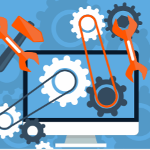

In [29]:
open_data_group

<Item title:"Indicator 14.a.1: National ocean science expenditure as a share of total research and development funding (percent)" type:Feature Layer Collection owner:unstats_admin>
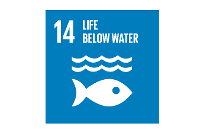

In [30]:
odg_content = open_data_group.content()
odg_content[0]

In [31]:
odg_content_metadata = []
for i in odg_content:
    d = {}
    d['id'] = i.id
    d['title'] = i.title
    d['type'] = i.type
    d['owner'] = i.owner
    d['tags'] = i.tags
    d['description'] = i.description
    d['snippet'] = i.snippet
    d['access'] = i.access
    d['thumbnail'] = i.thumbnail
    d['categories'] = i.categories
    odg_content_metadata.append(d)

odg_content_metadata

[{'id': '4c18088af2434cd0a2507e8238a594c3',
  'title': 'Indicator 14.a.1: National ocean science expenditure as a share of total research and development funding (percent)',
  'type': 'Feature Service',
  'owner': 'unstats_admin',
  'tags': ['means of implementation',
   'marine resources',
   'marine ecosystems',
   '2018.Q2.G.01'],
  'description': '<p><strong>Series ER_RDE_OSEX: </strong>National ocean science expenditure as a share of total research and development funding (%)</p><p><strong>Indicator 14.a.1: </strong>Proportion of total research budget allocated to research in the field of marine technology</p><p><strong>Target 14.a: </strong>Increase scientific knowledge, develop research capacity and transfer marine technology, taking into account the Intergovernmental Oceanographic Commission Criteria and Guidelines on the Transfer of Marine Technology, in order to improve ocean health and to enhance the contribution of marine biodiversity to the development of developing countr

## 6.2 Data inputs

In [32]:
# 1. csv metadata
series_metadata = get_series_metadata(metadata_dir + 'metadata.json', False)

# 2.  layer info template
layer_info = get_series_metadata(metadata_dir + 'layerinfo.json', False)


In [33]:
goal_properties = list(series_metadata[0].keys())
target_properties = list(series_metadata[1]['targets'][0].keys())
indicator_properties = list(series_metadata[1]['targets'][0]['indicators'][0].keys())
series_properties = list(series_metadata[1]['targets'][0]['indicators'][0]['series'][0].keys())

#goal_properties
#target_properties
#indicator_properties
#series_properties

In [34]:
layer_info_properties = list(layer_info.keys())
#layer_info_properties

## 6.3 Publishing loop

In [55]:
sdgTree = series_metadata.copy()  # Produces a shallow copy of series_metadata

for g in sdgTree:
    if g['code'] not in [ '5', '6', '7','8', '9','10','11','12','13','14','15','16','17']:
        continue
    for t in g['targets']:
        #if t['code'] not in ['16.8', '16.9', '16.10', '16.a', '16.b']:
        #    continue
        
        for i in t['indicators']:
            #if i['reference'] != '13.1.3':
            #    continue
            if 'series' in i.keys():
                for s in i['series']:

                    #if s['code'] != 'SE_MAT_PROF':
                    #    continue

                    print('\nProcessing series code:', i['reference'], s['code'])
                    
                    this_g = {k: g[k] for k in g.keys() if k not in ['targets']}
                    #this_g
                    #print('\n')
                    this_t = {k: t[k] for k in t.keys() if k not in ['indicators']}
                    #this_t
                    #print('\n')
                    this_i = {k: i[k] for k in i.keys() if k not in ['series']}
                    #this_i
                    #print('\n')
                    #s
                    
                    s_card = build_series_card(this_g,this_t,this_i,s)
                    
                    #s_card
                    
                    #if property_update_only:
                    #    online_item = find_online_item(s_card['title'], 
                    #                                   online_username, 
                    #                                   gis_online_connection)
                    #
                    #
                    #   if online_item is None:
                    #       failed_series.append(s['code'])
                    #   else:
                    #       online_item.update(item_properties=s_card, 
                    #                          thumbnail=g['thumbnail'])
                    #
                    #       if(update_symbology):
                    #           generate_renderer_infomation(feature_item=online_item,
                    #                                        statistic_field = 'value_latest_year',
                    #                                        layer_info = layer_info,
                    #                                        color=g['rgb'])     
                    #else:
                    
                    #this_g['thumbnail']
                    #layer_info
                    #this_g['rgb']

                    online_item = publish_csv(this_g,
                                              this_t,
                                              this_i,
                                              s, 
                                              item_properties=s_card,
                                              thumbnail=this_g['thumbnail'],
                                              layer_info = layer_info, 
                                              gis_online_connection= gis_online_connection,
                                              data_dir = data_dir,
                                              online_username = online_username,
                                              statistic_field = 'value_latest_year',
                                              property_update_only=False, 
                                              color=this_g['rgb'])

                    

                    #Only set the sharing when updating or publishing
                    if online_item is not None:
                        if update_sharing:
                            # Share this content with the open data group
                            online_item.share(everyone=False, 
                                              org=True, 
                                              groups=open_data_group["id"],
                                              allow_members_to_edit=False)

                        #display(online_item)
                        # Update the Group Information with Data from the Indicator and targets
                        update_item_categories(online_item,
                                               g["code"], 
                                               t["code"],
                                               gis_online_connection)

                        #open_data_group.update(tags=open_data_group["tags"] + [series["code"]])
                    else:
                        failed_series.append(s["code"])


        
        



Processing series code: 5.1.1 SG_LGL_GENEQLFP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.1.1_Series_SG_LGL_GENEQLFP.csv'

Searching for SG_LGL_GENEQLFP_5_1_1_2019Q2G01
 -- Item SG_LGL_GENEQLFP_5_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '19dea7eab1924ed28a17bf7415555e2c'}

{'results': [{'itemId': '19dea7eab1924ed28a17bf7415555e2c', 'success': True}]}

Processing series code: 5.1.1 SG_LGL_GENEQVAW


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.1.1_Series_SG_LGL_GENEQVAW.csv'

Searching for SG_LGL_GENEQVAW_5_1_1_2019Q2G01
 -- Item SG_LGL_GENEQVAW_5_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '22a82d19db7c4d72a11aa00ba76f3dc7'}

{'results': [{'itemId': '22a82d19db7c4d72a11aa00ba76f3dc7', 'success': True}]}

Processing series code: 5.1.1 SG_LGL_GENEQEMP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.1.1_Series_SG_LGL_GENEQEMP.csv'

Searching for SG_LGL_GENEQEMP_5_1_1_2019Q2G01
 -- Item SG_LGL_GENEQEMP_5_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd8001b25e562492384a078e72025a678'}

{'results': [{'itemId': 'd8001b25e562492384a078e72025a678', 'success': True}]}

Processing series code: 5.1.1 SG_LGL_GENEQMAR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.1.1_Series_SG_LGL_GENEQMAR.csv'

Searching for SG_LGL_GENEQMAR_5_1_1_2019Q2G01
 -- Item SG_LGL_GENEQMAR_5_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd547e5877d1a490f83340af52f1ccea6'}

{'results': [{'itemId': 'd547e5877d1a490f83340af52f1ccea6', 'success': True}]}

Processing series code: 5.2.1 VC_VAW_MARR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.2.1_Series_VC_VAW_MARR.csv'

Searching for VC_VAW_MARR_5_2_1_2019Q2G01
 -- Item VC_VAW_MARR_5_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '5fa1cf4fd4db4ccd9188a81788a7d84b'}

{'results': [{'itemId': '5fa1cf4fd4db4ccd9188a81788a7d84b', 'success': True}]}

Processing series code: 5.3.1 SP_DYN_MRBF18


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.3.1_Series_SP_DYN_MRBF18.csv'

Searching for SP_DYN_MRBF18_5_3_1_2019Q2G01
 -- Item SP_DYN_MRBF18_5_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c87948a7e6ab4aec92abffb70bab4e7c'}

{'results': [{'itemId': 'c87948a7e6ab4aec92abffb70bab4e7c', 'success': True}]}

Processing series code: 5.3.1 SP_DYN_MRBF15


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.3.1_Series_SP_DYN_MRBF15.csv'

Searching for SP_DYN_MRBF15_5_3_1_2019Q2G01
 -- Item SP_DYN_MRBF15_5_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0be315e76bea42529b3811c8d79bc588'}

{'results': [{'itemId': '0be315e76bea42529b3811c8d79bc588', 'success': True}]}

Processing series code: 5.3.2 SH_STA_FGMS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.3.2_Series_SH_STA_FGMS.csv'

Searching for SH_STA_FGMS_5_3_2_2019Q2G01
 -- Item SH_STA_FGMS_5_3_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '6fe7efaa68ed422497fdfdad1e38788c'}

{'results': [{'itemId': '6fe7efaa68ed422497fdfdad1e38788c', 'success': True}]}

Processing series code: 5.4.1 SL_DOM_TSPDCW


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.4.1_Series_SL_DOM_TSPDCW.csv'

Searching for SL_DOM_TSPDCW_5_4_1_2019Q2G01
 -- Item SL_DOM_TSPDCW_5_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '906b5a1246f04416a1c36a6178eb37a7'}

{'results': [{'itemId': '906b5a1246f04416a1c36a6178eb37a7', 'success': True}]}

Processing series code: 5.4.1 SL_DOM_TSPDDC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.4.1_Series_SL_DOM_TSPDDC.csv'

Searching for SL_DOM_TSPDDC_5_4_1_2019Q2G01
 -- Item SL_DOM_TSPDDC_5_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '53a80ff8d40f48848f23d03779d2fd75'}

{'results': [{'itemId': '53a80ff8d40f48848f23d03779d2fd75', 'success': True}]}

Processing series code: 5.4.1 SL_DOM_TSPD


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.4.1_Series_SL_DOM_TSPD.csv'

Searching for SL_DOM_TSPD_5_4_1_2019Q2G01
 -- Item SL_DOM_TSPD_5_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'dd7df028292646b3a5d2e40bce6e804c'}

{'results': [{'itemId': 'dd7df028292646b3a5d2e40bce6e804c', 'success': True}]}

Processing series code: 5.5.1 SG_GEN_PARLN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.5.1_Series_SG_GEN_PARLN.csv'

Searching for SG_GEN_PARLN_5_5_1_2019Q2G01
 -- Item SG_GEN_PARLN_5_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd13960a703b743948409b0b4716cd6b0'}

{'results': [{'itemId': 'd13960a703b743948409b0b4716cd6b0', 'success': True}]}

Processing series code: 5.5.1 SG_GEN_PARLNT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.5.1_Series_SG_GEN_PARLNT.csv'

Searching for SG_GEN_PARLNT_5_5_1_2019Q2G01
 -- Item SG_GEN_PARLNT_5_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '4572412cf4cb45bfaeee5f7bb158eed6'}

{'results': [{'itemId': '4572412cf4cb45bfaeee5f7bb158eed6', 'success': True}]}

Processing series code: 5.5.1 SG_GEN_PARL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.5.1_Series_SG_GEN_PARL.csv'

Searching for SG_GEN_PARL_5_5_1_2019Q2G01
 -- Item SG_GEN_PARL_5_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '29b8dbe8209c4966802edf3a38623f2c'}

{'results': [{'itemId': '29b8dbe8209c4966802edf3a38623f2c', 'success': True}]}

Processing series code: 5.5.1 SG_GEN_LOCGELS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.5.1_Series_SG_GEN_LOCGELS.csv'

Searching for SG_GEN_LOCGELS_5_5_1_2019Q2G01
 -- Item SG_GEN_LOCGELS_5_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'df338eed05b94460bd38f86fb9e7ce25'}

{'results': [{'itemId': 'df338eed05b94460bd38f86fb9e7ce25', 'success': True}]}

Processing series code: 5.5.2 IC_GEN_MGTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.5.2_Series_IC_GEN_MGTL.csv'

Searching for IC_GEN_MGTL_5_5_2_2019Q2G01
 -- Item IC_GEN_MGTL_5_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b23f560693c240b29009e570903b5ff2'}

{'results': [{'itemId': 'b23f560693c240b29009e570903b5ff2', 'success': True}]}

Processing series code: 5.5.2 IC_GEN_MGTN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.5.2_Series_IC_GEN_MGTN.csv'

Searching for IC_GEN_MGTN_5_5_2_2019Q2G01
 -- Item IC_GEN_MGTN_5_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '661b1b0c536e4dc58e70697f59cba4f6'}

{'results': [{'itemId': '661b1b0c536e4dc58e70697f59cba4f6', 'success': True}]}

Processing series code: 5.6.1 SH_FPL_INFM


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.6.1_Series_SH_FPL_INFM.csv'

Searching for SH_FPL_INFM_5_6_1_2019Q2G01
 -- Item SH_FPL_INFM_5_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '42620f00987a4439be9fcc3bf424d95b'}

{'results': [{'itemId': '42620f00987a4439be9fcc3bf424d95b', 'success': True}]}

Processing series code: 5.6.1 SH_FPL_INFMSR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.6.1_Series_SH_FPL_INFMSR.csv'

Searching for SH_FPL_INFMSR_5_6_1_2019Q2G01
 -- Item SH_FPL_INFMSR_5_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9c731f74577c4c2ca54d6d5de896967b'}

{'results': [{'itemId': '9c731f74577c4c2ca54d6d5de896967b', 'success': True}]}

Processing series code: 5.6.1 SH_FPL_INFMCU


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.6.1_Series_SH_FPL_INFMCU.csv'

Searching for SH_FPL_INFMCU_5_6_1_2019Q2G01
 -- Item SH_FPL_INFMCU_5_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '5b6f81c721e548a290dc3954a12f949b'}

{'results': [{'itemId': '5b6f81c721e548a290dc3954a12f949b', 'success': True}]}

Processing series code: 5.6.1 SH_FPL_INFMRH


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.6.1_Series_SH_FPL_INFMRH.csv'

Searching for SH_FPL_INFMRH_5_6_1_2019Q2G01
 -- Item SH_FPL_INFMRH_5_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9c5616ca58e3434fb4ebf221d66bc5c4'}

{'results': [{'itemId': '9c5616ca58e3434fb4ebf221d66bc5c4', 'success': True}]}

Processing series code: 5.b.1 IT_MOB_OWN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.b.1_Series_IT_MOB_OWN.csv'

Searching for IT_MOB_OWN_5_b_1_2019Q2G01
 -- Item IT_MOB_OWN_5_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '8cc97a0a4a1a43e6994c5817d85fb7e7'}

{'results': [{'itemId': '8cc97a0a4a1a43e6994c5817d85fb7e7', 'success': True}]}

Processing series code: 5.c.1 SG_GEN_EQPWN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_5.c.1_Series_SG_GEN_EQPWN.csv'

Searching for SG_GEN_EQPWN_5_c_1_2019Q2G01
 -- Item SG_GEN_EQPWN_5_c_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '48bebbc623f648ac9fb157bb34410257'}

{'results': [{'itemId': '48bebbc623f648ac9fb157bb34410257', 'success': True}]}

Processing series code: 6.1.1 SH_H2O_SAFE


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.1.1_Series_SH_H2O_SAFE.csv'

Searching for SH_H2O_SAFE_6_1_1_2019Q2G01
 -- Item SH_H2O_SAFE_6_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'db95089773654b6898ef4af01c440140'}

{'results': [{'itemId': 'db95089773654b6898ef4af01c440140', 'success': True}]}

Processing series code: 6.2.1 SH_SAN_HNDWSH


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.2.1_Series_SH_SAN_HNDWSH.csv'

Searching for SH_SAN_HNDWSH_6_2_1_2019Q2G01
 -- Item SH_SAN_HNDWSH_6_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e68e470d4e084d4b9f74d6de7594bbad'}

{'results': [{'itemId': 'e68e470d4e084d4b9f74d6de7594bbad', 'success': True}]}

Processing series code: 6.2.1 SH_SAN_SAFE


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.2.1_Series_SH_SAN_SAFE.csv'

Searching for SH_SAN_SAFE_6_2_1_2019Q2G01
 -- Item SH_SAN_SAFE_6_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '961186c499834224bb09e32f68092855'}

{'results': [{'itemId': '961186c499834224bb09e32f68092855', 'success': True}]}

Processing series code: 6.2.1 SH_SAN_DEFECT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.2.1_Series_SH_SAN_DEFECT.csv'

Searching for SH_SAN_DEFECT_6_2_1_2019Q2G01
 -- Item SH_SAN_DEFECT_6_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '6d84807ee23f4ddbaf2b9ba0768c8a12'}

{'results': [{'itemId': '6d84807ee23f4ddbaf2b9ba0768c8a12', 'success': True}]}

Processing series code: 6.3.1 EN_WWT_WWDS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.3.1_Series_EN_WWT_WWDS.csv'

Searching for EN_WWT_WWDS_6_3_1_2019Q2G01
 -- Item EN_WWT_WWDS_6_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e1b826c0d14f4c139c5dba98a6305cff'}

{'results': [{'itemId': 'e1b826c0d14f4c139c5dba98a6305cff', 'success': True}]}

Processing series code: 6.3.2 EN_H2O_OPAMBQ


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.3.2_Series_EN_H2O_OPAMBQ.csv'

Searching for EN_H2O_OPAMBQ_6_3_2_2019Q2G01
 -- Item EN_H2O_OPAMBQ_6_3_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a98d42208fc14f2683702ac19d841197'}

{'results': [{'itemId': 'a98d42208fc14f2683702ac19d841197', 'success': True}]}

Processing series code: 6.3.2 EN_H2O_RVAMBQ


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.3.2_Series_EN_H2O_RVAMBQ.csv'

Searching for EN_H2O_RVAMBQ_6_3_2_2019Q2G01
 -- Item EN_H2O_RVAMBQ_6_3_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd7a02226881b4e3780072f250d443d46'}

{'results': [{'itemId': 'd7a02226881b4e3780072f250d443d46', 'success': True}]}

Processing series code: 6.3.2 EN_H2O_GRAMBQ


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.3.2_Series_EN_H2O_GRAMBQ.csv'

Searching for EN_H2O_GRAMBQ_6_3_2_2019Q2G01
 -- Item EN_H2O_GRAMBQ_6_3_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b48f6879dd5e4bd39ddedb44c53145f1'}

{'results': [{'itemId': 'b48f6879dd5e4bd39ddedb44c53145f1', 'success': True}]}

Processing series code: 6.3.2 EN_H2O_WBAMBQ


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.3.2_Series_EN_H2O_WBAMBQ.csv'

Searching for EN_H2O_WBAMBQ_6_3_2_2019Q2G01
 -- Item EN_H2O_WBAMBQ_6_3_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '27ed1d89d5f14ec4a660d173d4e624da'}

{'results': [{'itemId': '27ed1d89d5f14ec4a660d173d4e624da', 'success': True}]}

Processing series code: 6.4.1 ER_H2O_WUEYST


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.4.1_Series_ER_H2O_WUEYST.csv'

Searching for ER_H2O_WUEYST_6_4_1_2019Q2G01
 -- Item ER_H2O_WUEYST_6_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '6a6e50a80d634f218cd80ebc6d06a5a3'}

{'results': [{'itemId': '6a6e50a80d634f218cd80ebc6d06a5a3', 'success': True}]}

Processing series code: 6.4.2 ER_H2O_STRESS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.4.2_Series_ER_H2O_STRESS.csv'

Searching for ER_H2O_STRESS_6_4_2_2019Q2G01
 -- Item ER_H2O_STRESS_6_4_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '38451bef4070432fbeb415ba4510965e'}

{'results': [{'itemId': '38451bef4070432fbeb415ba4510965e', 'success': True}]}

Processing series code: 6.5.1 ER_H2O_IWRMD


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.5.1_Series_ER_H2O_IWRMD.csv'

Searching for ER_H2O_IWRMD_6_5_1_2019Q2G01
 -- Item ER_H2O_IWRMD_6_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '11f76a8f585a4817a9b687631cf78b63'}

{'results': [{'itemId': '11f76a8f585a4817a9b687631cf78b63', 'success': True}]}

Processing series code: 6.5.1 ER_H2O_IWRMP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.5.1_Series_ER_H2O_IWRMP.csv'


Processing series code: 6.5.2 EG_TBA_H2CO


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.5.2_Series_EG_TBA_H2CO.csv'

Searching for EG_TBA_H2CO_6_5_2_2019Q2G01
 -- Item EG_TBA_H2CO_6_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '608ea511d90d42d28624efc0c77d8ac7'}

{'results': [{'itemId': '608ea511d90d42d28624efc0c77d8ac7', 'success': True}]}

Processing series code: 6.5.2 EG_TBA_H2COAQ


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.5.2_Series_EG_TBA_H2COAQ.csv'

Searching for EG_TBA_H2COAQ_6_5_2_2019Q2G01
 -- Item EG_TBA_H2COAQ_6_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd52f9b57f74545dc85194b0db237d1c0'}

{'results': [{'itemId': 'd52f9b57f74545dc85194b0db237d1c0', 'success': True}]}

Processing series code: 6.5.2 EG_TBA_H2CORL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.5.2_Series_EG_TBA_H2CORL.csv'

Searching for EG_TBA_H2CORL_6_5_2_2019Q2G01
 -- Item EG_TBA_H2CORL_6_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '71973ced2c74476f87c0b59eb607b710'}

{'results': [{'itemId': '71973ced2c74476f87c0b59eb607b710', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_PMPR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_PMPR.csv'

Searching for EN_WBE_PMPR_6_6_1_2019Q2G01
 -- Item EN_WBE_PMPR_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '66fa544fc65c4734bbf010e0d1b3f2dd'}

{'results': [{'itemId': '66fa544fc65c4734bbf010e0d1b3f2dd', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_PMNR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_PMNR.csv'

Searching for EN_WBE_PMNR_6_6_1_2019Q2G01
 -- Item EN_WBE_PMNR_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'ad32b3d4781d4da1b265fbf6017ea3ab'}

{'results': [{'itemId': 'ad32b3d4781d4da1b265fbf6017ea3ab', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_PMPP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_PMPP.csv'

Searching for EN_WBE_PMPP_6_6_1_2019Q2G01
 -- Item EN_WBE_PMPP_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '6dc1215042594eb5834e2af14c8afc4e'}

{'results': [{'itemId': '6dc1215042594eb5834e2af14c8afc4e', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_PMPN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_PMPN.csv'

Searching for EN_WBE_PMPN_6_6_1_2019Q2G01
 -- Item EN_WBE_PMPN_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c5defcc7bf504bbe84b88aa901b786bd'}

{'results': [{'itemId': 'c5defcc7bf504bbe84b88aa901b786bd', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDETOT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDETOT.csv'

Searching for EN_WBE_NDETOT_6_6_1_2019Q2G01
 -- Item EN_WBE_NDETOT_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '08c752f60a9c4faf95cb1bba4df2d48a'}

{'results': [{'itemId': '08c752f60a9c4faf95cb1bba4df2d48a', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDOPW


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDOPW.csv'

Searching for EN_WBE_NDOPW_6_6_1_2019Q2G01
 -- Item EN_WBE_NDOPW_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f2b19892c8bc4dbf9f8f8d82f064e83c'}

{'results': [{'itemId': 'f2b19892c8bc4dbf9f8f8d82f064e83c', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDQLGRW


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDQLGRW.csv'

Searching for EN_WBE_NDQLGRW_6_6_1_2019Q2G01
 -- Item EN_WBE_NDQLGRW_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '431256c7eb584fc4addce71a7c3aa12a'}

{'results': [{'itemId': '431256c7eb584fc4addce71a7c3aa12a', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDQLOPW


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDQLOPW.csv'

Searching for EN_WBE_NDQLOPW_6_6_1_2019Q2G01
 -- Item EN_WBE_NDQLOPW_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b929fa042c5a486dbce3046039b3b9f7'}

{'results': [{'itemId': 'b929fa042c5a486dbce3046039b3b9f7', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDQLRVR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDQLRVR.csv'

Searching for EN_WBE_NDQLRVR_6_6_1_2019Q2G01
 -- Item EN_WBE_NDQLRVR_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a49bf884154640caa1d2d7f454080c3e'}

{'results': [{'itemId': 'a49bf884154640caa1d2d7f454080c3e', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDQLTOT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDQLTOT.csv'

Searching for EN_WBE_NDQLTOT_6_6_1_2019Q2G01
 -- Item EN_WBE_NDQLTOT_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b5a8397f89134945aa584fa418522011'}

{'results': [{'itemId': 'b5a8397f89134945aa584fa418522011', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDQTGRW


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDQTGRW.csv'

Searching for EN_WBE_NDQTGRW_6_6_1_2019Q2G01
 -- Item EN_WBE_NDQTGRW_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '57b78f74be68422b8b0522abf0aa5d48'}

{'results': [{'itemId': '57b78f74be68422b8b0522abf0aa5d48', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDQTOPW


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDQTOPW.csv'

Searching for EN_WBE_NDQTOPW_6_6_1_2019Q2G01
 -- Item EN_WBE_NDQTOPW_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '8f6966a322cf42ad94cd30fbdec65da6'}

{'results': [{'itemId': '8f6966a322cf42ad94cd30fbdec65da6', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDQTRVR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDQTRVR.csv'

Searching for EN_WBE_NDQTRVR_6_6_1_2019Q2G01
 -- Item EN_WBE_NDQTRVR_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e439a0fac91d4bec8af4eda11c4c32a5'}

{'results': [{'itemId': 'e439a0fac91d4bec8af4eda11c4c32a5', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDQTTOT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDQTTOT.csv'

Searching for EN_WBE_NDQTTOT_6_6_1_2019Q2G01
 -- Item EN_WBE_NDQTTOT_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '21ae4918bde14ed29159f2e0b1450e5e'}

{'results': [{'itemId': '21ae4918bde14ed29159f2e0b1450e5e', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDRV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDRV.csv'

Searching for EN_WBE_NDRV_6_6_1_2019Q2G01
 -- Item EN_WBE_NDRV_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b31e81ae7353470c861947b27fe976c6'}

{'results': [{'itemId': 'b31e81ae7353470c861947b27fe976c6', 'success': True}]}

Processing series code: 6.6.1 EN_WBE_NDWTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.6.1_Series_EN_WBE_NDWTL.csv'

Searching for EN_WBE_NDWTL_6_6_1_2019Q2G01
 -- Item EN_WBE_NDWTL_6_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '09e37e7a01f64638a4463598289ca0bb'}

{'results': [{'itemId': '09e37e7a01f64638a4463598289ca0bb', 'success': True}]}

Processing series code: 6.a.1 DC_TOF_WASHL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.a.1_Series_DC_TOF_WASHL.csv'

Searching for DC_TOF_WASHL_6_a_1_2019Q2G01
 -- Item DC_TOF_WASHL_6_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e00ec50b5ef54e2aa9013d457ecfd0a9'}

{'results': [{'itemId': 'e00ec50b5ef54e2aa9013d457ecfd0a9', 'success': True}]}

Processing series code: 6.b.1 ER_WAT_PROCED


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.b.1_Series_ER_WAT_PROCED.csv'


Processing series code: 6.b.1 ER_H2O_PARTIC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.b.1_Series_ER_H2O_PARTIC.csv'


Processing series code: 6.b.1 ER_H2O_PROCED


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.b.1_Series_ER_H2O_PROCED.csv'


Processing series code: 6.b.1 ER_WAT_PARTIC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.b.1_Series_ER_WAT_PARTIC.csv'


Processing series code: 6.b.1 ER_H2O_RURP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.b.1_Series_ER_H2O_RURP.csv'

Searching for ER_H2O_RURP_6_b_1_2019Q2G01
 -- Item ER_H2O_RURP_6_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '5edd9fa1fde5476b9c044f40af95afb8'}

{'results': [{'itemId': '5edd9fa1fde5476b9c044f40af95afb8', 'success': True}]}

Processing series code: 6.b.1 ER_H2O_PRDU


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.b.1_Series_ER_H2O_PRDU.csv'

Searching for ER_H2O_PRDU_6_b_1_2019Q2G01
 -- Item ER_H2O_PRDU_6_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '8773534c3ac64bda83f7e089b692fb00'}

{'results': [{'itemId': '8773534c3ac64bda83f7e089b692fb00', 'success': True}]}

Processing series code: 6.b.1 ER_WAT_PART


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.b.1_Series_ER_WAT_PART.csv'

Searching for ER_WAT_PART_6_b_1_2019Q2G01
 -- Item ER_WAT_PART_6_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c16a558ff99e445ea2178e1c77953b5b'}

{'results': [{'itemId': 'c16a558ff99e445ea2178e1c77953b5b', 'success': True}]}

Processing series code: 6.b.1 ER_WAT_PRDU


'../../data/unsd/2019.Q2.G.01/csv_Indicator_6.b.1_Series_ER_WAT_PRDU.csv'

Searching for ER_WAT_PRDU_6_b_1_2019Q2G01
 -- Item ER_WAT_PRDU_6_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '24a5778ceac74ce687cfa21cb85e33f4'}

{'results': [{'itemId': '24a5778ceac74ce687cfa21cb85e33f4', 'success': True}]}

Processing series code: 7.1.1 EG_ELC_ACCS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_7.1.1_Series_EG_ELC_ACCS.csv'

Searching for EG_ELC_ACCS_7_1_1_2019Q2G01
 -- Item EG_ELC_ACCS_7_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'efe5c0628d4749b38b4be596740e2956'}

{'results': [{'itemId': 'efe5c0628d4749b38b4be596740e2956', 'success': True}]}

Processing series code: 7.1.2 EG_EGY_CLEAN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_7.1.2_Series_EG_EGY_CLEAN.csv'

Searching for EG_EGY_CLEAN_7_1_2_2019Q2G01
 -- Item EG_EGY_CLEAN_7_1_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '1dc5d53ca0834e8da4594e86180cf55e'}

{'results': [{'itemId': '1dc5d53ca0834e8da4594e86180cf55e', 'success': True}]}

Processing series code: 7.2.1 EG_FEC_RNEW


'../../data/unsd/2019.Q2.G.01/csv_Indicator_7.2.1_Series_EG_FEC_RNEW.csv'

Searching for EG_FEC_RNEW_7_2_1_2019Q2G01
 -- Item EG_FEC_RNEW_7_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '10a8bc343fa54dc7a5def8f234e4ca15'}

{'results': [{'itemId': '10a8bc343fa54dc7a5def8f234e4ca15', 'success': True}]}

Processing series code: 7.3.1 EG_EGY_PRIM


'../../data/unsd/2019.Q2.G.01/csv_Indicator_7.3.1_Series_EG_EGY_PRIM.csv'

Searching for EG_EGY_PRIM_7_3_1_2019Q2G01
 -- Item EG_EGY_PRIM_7_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f25065ff20b149a8b55e2ab56ece7da4'}

{'results': [{'itemId': 'f25065ff20b149a8b55e2ab56ece7da4', 'success': True}]}

Processing series code: 7.a.1 EG_IFF_RANDN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_7.a.1_Series_EG_IFF_RANDN.csv'

Searching for EG_IFF_RANDN_7_a_1_2019Q2G01
 -- Item EG_IFF_RANDN_7_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '174868e096e5417989316e64752b8d6d'}

{'results': [{'itemId': '174868e096e5417989316e64752b8d6d', 'success': True}]}

Processing series code: 8.1.1 NY_GDP_PCAP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.1.1_Series_NY_GDP_PCAP.csv'

Searching for NY_GDP_PCAP_8_1_1_2019Q2G01
 -- Item NY_GDP_PCAP_8_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Folder not found for given owner
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder
Folder not found for given owner


{'notSharedWith': [], 'itemId': '97f4c9aba77f4fed8f217784dfdd649f'}

{'results': [{'itemId': '97f4c9aba77f4fed8f217784dfdd649f', 'success': True}]}

Processing series code: 8.2.1 SL_EMP_PCAP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.2.1_Series_SL_EMP_PCAP.csv'

Searching for SL_EMP_PCAP_8_2_1_2019Q2G01
 -- Item SL_EMP_PCAP_8_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Folder not found for given owner
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder
Folder not found for given owner


{'notSharedWith': [], 'itemId': 'aeb0fdcfc1694cdeb26462aea2628b7e'}

{'results': [{'itemId': 'aeb0fdcfc1694cdeb26462aea2628b7e', 'success': True}]}

Processing series code: 8.3.1 SL_ISV_IFRM


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.3.1_Series_SL_ISV_IFRM.csv'

Searching for SL_ISV_IFRM_8_3_1_2019Q2G01
 -- Item SL_ISV_IFRM_8_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Folder not found for given owner
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder
Folder not found for given owner


{'notSharedWith': [], 'itemId': '6e0e95a8dba041cf9ada90f553edce75'}

{'results': [{'itemId': '6e0e95a8dba041cf9ada90f553edce75', 'success': True}]}

Processing series code: 8.4.1 EN_MAT_FTPRPG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.4.1_Series_EN_MAT_FTPRPG.csv'


Processing series code: 8.4.1 EN_MAT_FTPRPC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.4.1_Series_EN_MAT_FTPRPC.csv'


Processing series code: 8.4.1 EN_MAT_FTPRTN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.4.1_Series_EN_MAT_FTPRTN.csv'


Processing series code: 8.4.2 EN_MAT_DOMCMPT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.4.2_Series_EN_MAT_DOMCMPT.csv'

Searching for EN_MAT_DOMCMPT_8_4_2_2019Q2G01
 -- Item EN_MAT_DOMCMPT_8_4_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Folder not found for given owner
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder
Folder not found for given owner


{'notSharedWith': [], 'itemId': 'd2c72381eb134a6eb94b6508db6fbef6'}

{'results': [{'itemId': 'd2c72381eb134a6eb94b6508db6fbef6', 'success': True}]}

Processing series code: 8.4.2 EN_MAT_DOMCMPG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.4.2_Series_EN_MAT_DOMCMPG.csv'

Searching for EN_MAT_DOMCMPG_8_4_2_2019Q2G01
 -- Item EN_MAT_DOMCMPG_8_4_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Folder not found for given owner
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder
Folder not found for given owner


{'notSharedWith': [], 'itemId': '16252c6b77c24b4191711a50dd91ed93'}

{'results': [{'itemId': '16252c6b77c24b4191711a50dd91ed93', 'success': True}]}

Processing series code: 8.4.2 EN_MAT_DOMCMPC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.4.2_Series_EN_MAT_DOMCMPC.csv'

Searching for EN_MAT_DOMCMPC_8_4_2_2019Q2G01
 -- Item EN_MAT_DOMCMPC_8_4_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Folder not found for given owner
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder
Folder not found for given owner


{'notSharedWith': [], 'itemId': 'b49f2b4b8f3a4616a0075c1eebe0fa0f'}

{'results': [{'itemId': 'b49f2b4b8f3a4616a0075c1eebe0fa0f', 'success': True}]}

Processing series code: 8.5.1 SL_EMP_AEARN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.5.1_Series_SL_EMP_AEARN.csv'

Searching for SL_EMP_AEARN_8_5_1_2019Q2G01
 -- Item SL_EMP_AEARN_8_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Folder not found for given owner
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder
Folder not found for given owner


{'notSharedWith': [], 'itemId': 'c10f638d227d46e3b52ba2051339375c'}

{'results': [{'itemId': 'c10f638d227d46e3b52ba2051339375c', 'success': True}]}

Processing series code: 8.5.2 SL_TLF_UEM


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.5.2_Series_SL_TLF_UEM.csv'

Searching for SL_TLF_UEM_8_5_2_2019Q2G01
 -- Item SL_TLF_UEM_8_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Folder not found for given owner
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder
Folder not found for given owner


{'notSharedWith': [], 'itemId': 'c386199f78d041d5b1c7b5403ed6bc52'}

{'results': [{'itemId': 'c386199f78d041d5b1c7b5403ed6bc52', 'success': True}]}

Processing series code: 8.5.2 SL_TLF_UEMDIS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.5.2_Series_SL_TLF_UEMDIS.csv'

Searching for SL_TLF_UEMDIS_8_5_2_2019Q2G01
 -- Item SL_TLF_UEMDIS_8_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Folder not found for given owner
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder
Folder not found for given owner


{'notSharedWith': [], 'itemId': '4d19b22fc060420fa35cf949cc8c378d'}

{'results': [{'itemId': '4d19b22fc060420fa35cf949cc8c378d', 'success': True}]}

Processing series code: 8.6.1 SL_TLF_NEET


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.6.1_Series_SL_TLF_NEET.csv'

Searching for SL_TLF_NEET_8_6_1_2019Q2G01
 -- Item SL_TLF_NEET_8_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '5e6874c6f26c4b2bbf9897adad94f892'}

{'results': [{'itemId': '5e6874c6f26c4b2bbf9897adad94f892', 'success': True}]}

Processing series code: 8.7.1 SL_TLF_CHLDEC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.7.1_Series_SL_TLF_CHLDEC.csv'

Searching for SL_TLF_CHLDEC_8_7_1_2019Q2G01
 -- Item SL_TLF_CHLDEC_8_7_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b6ffddbf6ec645a68a725f723373e76a'}

{'results': [{'itemId': 'b6ffddbf6ec645a68a725f723373e76a', 'success': True}]}

Processing series code: 8.7.1 SL_TLF_CHLDEA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.7.1_Series_SL_TLF_CHLDEA.csv'

Searching for SL_TLF_CHLDEA_8_7_1_2019Q2G01
 -- Item SL_TLF_CHLDEA_8_7_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....


{'notSharedWith': [], 'itemId': 'ec736c93ab0746f7a9fb86dd1d926439'}

{'results': [{'itemId': 'ec736c93ab0746f7a9fb86dd1d926439', 'success': True}]}

Processing series code: 8.8.1 SL_EMP_FTLINJUR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.8.1_Series_SL_EMP_FTLINJUR.csv'

Searching for SL_EMP_FTLINJUR_8_8_1_2019Q2G01
 -- Item SL_EMP_FTLINJUR_8_8_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '52e8dfb95b7d43f795cc87cff04a9ad3'}

{'results': [{'itemId': '52e8dfb95b7d43f795cc87cff04a9ad3', 'success': True}]}

Processing series code: 8.8.1 SL_EMP_INJUR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.8.1_Series_SL_EMP_INJUR.csv'

Searching for SL_EMP_INJUR_8_8_1_2019Q2G01
 -- Item SL_EMP_INJUR_8_8_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd375d8f4e78d48b9b228bb74e2529dce'}

{'results': [{'itemId': 'd375d8f4e78d48b9b228bb74e2529dce', 'success': True}]}

Processing series code: 8.10.1 FB_ATM_TOTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.10.1_Series_FB_ATM_TOTL.csv'

Searching for FB_ATM_TOTL_8_10_1_2019Q2G01
 -- Item FB_ATM_TOTL_8_10_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '14e27c7d20af4693b67329a910463d52'}

{'results': [{'itemId': '14e27c7d20af4693b67329a910463d52', 'success': True}]}

Processing series code: 8.10.1 FB_CBK_BRCH


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.10.1_Series_FB_CBK_BRCH.csv'

Searching for FB_CBK_BRCH_8_10_1_2019Q2G01
 -- Item FB_CBK_BRCH_8_10_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9adbe0d648b847929e875910973a6660'}

{'results': [{'itemId': '9adbe0d648b847929e875910973a6660', 'success': True}]}

Processing series code: 8.10.2 FB_BNK_ACCSS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.10.2_Series_FB_BNK_ACCSS.csv'

Searching for FB_BNK_ACCSS_8_10_2_2019Q2G01
 -- Item FB_BNK_ACCSS_8_10_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '88416b8611e844b0a9ebaf15ad7ba4a4'}

{'results': [{'itemId': '88416b8611e844b0a9ebaf15ad7ba4a4', 'success': True}]}

Processing series code: 8.a.1 DC_TOF_TRDCMDL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.a.1_Series_DC_TOF_TRDCMDL.csv'

Searching for DC_TOF_TRDCMDL_8_a_1_2019Q2G01
 -- Item DC_TOF_TRDCMDL_8_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e3f884fba81740e0a8c31743d9c5a5e6'}

{'results': [{'itemId': 'e3f884fba81740e0a8c31743d9c5a5e6', 'success': True}]}

Processing series code: 8.a.1 DC_TOF_TRDDBMDL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.a.1_Series_DC_TOF_TRDDBMDL.csv'

Searching for DC_TOF_TRDDBMDL_8_a_1_2019Q2G01
 -- Item DC_TOF_TRDDBMDL_8_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0e7f37083e084d19bc586beb907ffe85'}

{'results': [{'itemId': '0e7f37083e084d19bc586beb907ffe85', 'success': True}]}

Processing series code: 8.a.1 DC_TOF_TRDDBML


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.a.1_Series_DC_TOF_TRDDBML.csv'

Searching for DC_TOF_TRDDBML_8_a_1_2019Q2G01
 -- Item DC_TOF_TRDDBML_8_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c82c44f990e04cf98fd11e2c0efe0fd7'}

{'results': [{'itemId': 'c82c44f990e04cf98fd11e2c0efe0fd7', 'success': True}]}

Processing series code: 8.a.1 DC_TOF_TRDCML


'../../data/unsd/2019.Q2.G.01/csv_Indicator_8.a.1_Series_DC_TOF_TRDCML.csv'

Searching for DC_TOF_TRDCML_8_a_1_2019Q2G01
 -- Item DC_TOF_TRDCML_8_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd58dbd107b9a4a66b45fe51fbb86a9f2'}

{'results': [{'itemId': 'd58dbd107b9a4a66b45fe51fbb86a9f2', 'success': True}]}

Processing series code: 9.1.2 IS_RDP_FRGVOL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.1.2_Series_IS_RDP_FRGVOL.csv'

Searching for IS_RDP_FRGVOL_9_1_2_2019Q2G01
 -- Item IS_RDP_FRGVOL_9_1_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9827c1115b394f8585898038f54f0be6'}

{'results': [{'itemId': '9827c1115b394f8585898038f54f0be6', 'success': True}]}

Processing series code: 9.1.2 IS_RDP_PFVOL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.1.2_Series_IS_RDP_PFVOL.csv'

Searching for IS_RDP_PFVOL_9_1_2_2019Q2G01
 -- Item IS_RDP_PFVOL_9_1_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '22836bd93c55492ebaf34567469d553c'}

{'results': [{'itemId': '22836bd93c55492ebaf34567469d553c', 'success': True}]}

Processing series code: 9.2.1 NV_IND_MANFPC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.2.1_Series_NV_IND_MANFPC.csv'

Searching for NV_IND_MANFPC_9_2_1_2019Q2G01
 -- Item NV_IND_MANFPC_9_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'ed6057a6f4754ccf8b580a57878912b6'}

{'results': [{'itemId': 'ed6057a6f4754ccf8b580a57878912b6', 'success': True}]}

Processing series code: 9.2.1 NV_IND_MANF


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.2.1_Series_NV_IND_MANF.csv'

Searching for NV_IND_MANF_9_2_1_2019Q2G01
 -- Item NV_IND_MANF_9_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '2148ac98ecf04161a5648beb637f2ced'}

{'results': [{'itemId': '2148ac98ecf04161a5648beb637f2ced', 'success': True}]}

Processing series code: 9.2.2 SL_TLF_MANF


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.2.2_Series_SL_TLF_MANF.csv'

Searching for SL_TLF_MANF_9_2_2_2019Q2G01
 -- Item SL_TLF_MANF_9_2_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '745c1d7f877a4ac5b9fdc72bcccf7d5b'}

{'results': [{'itemId': '745c1d7f877a4ac5b9fdc72bcccf7d5b', 'success': True}]}

Processing series code: 9.3.1 NV_IND_SSIS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.3.1_Series_NV_IND_SSIS.csv'

Searching for NV_IND_SSIS_9_3_1_2019Q2G01
 -- Item NV_IND_SSIS_9_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e50a59c1eb2f40f7b1e842b8ec7415f6'}

{'results': [{'itemId': 'e50a59c1eb2f40f7b1e842b8ec7415f6', 'success': True}]}

Processing series code: 9.3.2 FC_ACC_SSID


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.3.2_Series_FC_ACC_SSID.csv'

Searching for FC_ACC_SSID_9_3_2_2019Q2G01
 -- Item FC_ACC_SSID_9_3_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '4d4b297bae004e15bf1271c3e0831fa4'}

{'results': [{'itemId': '4d4b297bae004e15bf1271c3e0831fa4', 'success': True}]}

Processing series code: 9.4.1 EN_ATM_CO2


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.4.1_Series_EN_ATM_CO2.csv'

Searching for EN_ATM_CO2_9_4_1_2019Q2G01
 -- Item EN_ATM_CO2_9_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '7426388abf5e454881fcdc6f0c766128'}

{'results': [{'itemId': '7426388abf5e454881fcdc6f0c766128', 'success': True}]}

Processing series code: 9.4.1 EN_ATM_CO2MVA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.4.1_Series_EN_ATM_CO2MVA.csv'

Searching for EN_ATM_CO2MVA_9_4_1_2019Q2G01
 -- Item EN_ATM_CO2MVA_9_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '2fb4baf5cebd4ae5a733d734cbeafc33'}

{'results': [{'itemId': '2fb4baf5cebd4ae5a733d734cbeafc33', 'success': True}]}

Processing series code: 9.4.1 EN_ATM_CO2GDP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.4.1_Series_EN_ATM_CO2GDP.csv'

Searching for EN_ATM_CO2GDP_9_4_1_2019Q2G01
 -- Item EN_ATM_CO2GDP_9_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '36ff192d48504b34bbc8af3ff30f565b'}

{'results': [{'itemId': '36ff192d48504b34bbc8af3ff30f565b', 'success': True}]}

Processing series code: 9.5.1 GB_XPD_RSDV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.5.1_Series_GB_XPD_RSDV.csv'

Searching for GB_XPD_RSDV_9_5_1_2019Q2G01
 -- Item GB_XPD_RSDV_9_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '06bbe00c627d46f884b9caf36413ad97'}

{'results': [{'itemId': '06bbe00c627d46f884b9caf36413ad97', 'success': True}]}

Processing series code: 9.5.2 GB_POP_SCIERD


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.5.2_Series_GB_POP_SCIERD.csv'

Searching for GB_POP_SCIERD_9_5_2_2019Q2G01
 -- Item GB_POP_SCIERD_9_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e442b5b7845743e8960b230aa4de4e37'}

{'results': [{'itemId': 'e442b5b7845743e8960b230aa4de4e37', 'success': True}]}

Processing series code: 9.a.1 DC_TOF_INFRAL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.a.1_Series_DC_TOF_INFRAL.csv'

Searching for DC_TOF_INFRAL_9_a_1_2019Q2G01
 -- Item DC_TOF_INFRAL_9_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '40e98439f83e4e0284afdf64d8f59493'}

{'results': [{'itemId': '40e98439f83e4e0284afdf64d8f59493', 'success': True}]}

Processing series code: 9.b.1 NV_IND_TECH


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.b.1_Series_NV_IND_TECH.csv'

Searching for NV_IND_TECH_9_b_1_2019Q2G01
 -- Item NV_IND_TECH_9_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'cb950c85c7c7469a925650bda7b3002b'}

{'results': [{'itemId': 'cb950c85c7c7469a925650bda7b3002b', 'success': True}]}

Processing series code: 9.c.1 IT_MOB_NTWK


'../../data/unsd/2019.Q2.G.01/csv_Indicator_9.c.1_Series_IT_MOB_NTWK.csv'

Searching for IT_MOB_NTWK_9_c_1_2019Q2G01
 -- Item IT_MOB_NTWK_9_c_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'bcf2ed2c448a4a3bafe7ea8951d4a259'}

{'results': [{'itemId': 'bcf2ed2c448a4a3bafe7ea8951d4a259', 'success': True}]}

Processing series code: 10.1.1 SI_HEI_TOTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.1.1_Series_SI_HEI_TOTL.csv'

Searching for SI_HEI_TOTL_10_1_1_2019Q2G01
 -- Item SI_HEI_TOTL_10_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '688f22c20df3452298e61bc6016329b5'}

{'results': [{'itemId': '688f22c20df3452298e61bc6016329b5', 'success': True}]}

Processing series code: 10.1.1 SI_HEI_BTN40


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.1.1_Series_SI_HEI_BTN40.csv'

Searching for SI_HEI_BTN40_10_1_1_2019Q2G01
 -- Item SI_HEI_BTN40_10_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd8408ca5c21649f08185225611a4241c'}

{'results': [{'itemId': 'd8408ca5c21649f08185225611a4241c', 'success': True}]}

Processing series code: 10.4.1 SL_EMP_GTOTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.4.1_Series_SL_EMP_GTOTL.csv'

Searching for SL_EMP_GTOTL_10_4_1_2019Q2G01
 -- Item SL_EMP_GTOTL_10_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '54681bb23185478eb1e01e147bf32f5d'}

{'results': [{'itemId': '54681bb23185478eb1e01e147bf32f5d', 'success': True}]}

Processing series code: 10.5.1 FI_FSI_FSANL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.5.1_Series_FI_FSI_FSANL.csv'

Searching for FI_FSI_FSANL_10_5_1_2019Q2G01
 -- Item FI_FSI_FSANL_10_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f5a9e0f399b04ea9b3ed8e3f9c3ecb68'}

{'results': [{'itemId': 'f5a9e0f399b04ea9b3ed8e3f9c3ecb68', 'success': True}]}

Processing series code: 10.5.1 FI_FSI_FSERA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.5.1_Series_FI_FSI_FSERA.csv'

Searching for FI_FSI_FSERA_10_5_1_2019Q2G01
 -- Item FI_FSI_FSERA_10_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'bbee95bd53964e9596f43f904a951f55'}

{'results': [{'itemId': 'bbee95bd53964e9596f43f904a951f55', 'success': True}]}

Processing series code: 10.5.1 FI_FSI_FSKA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.5.1_Series_FI_FSI_FSKA.csv'

Searching for FI_FSI_FSKA_10_5_1_2019Q2G01
 -- Item FI_FSI_FSKA_10_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'bdd3686085714c31894e1c6a7baad5e8'}

{'results': [{'itemId': 'bdd3686085714c31894e1c6a7baad5e8', 'success': True}]}

Processing series code: 10.5.1 FI_FSI_FSKNL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.5.1_Series_FI_FSI_FSKNL.csv'

Searching for FI_FSI_FSKNL_10_5_1_2019Q2G01
 -- Item FI_FSI_FSKNL_10_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '6fbc91f34c3c46699639c6f431db8af3'}

{'results': [{'itemId': '6fbc91f34c3c46699639c6f431db8af3', 'success': True}]}

Processing series code: 10.5.1 FI_FSI_FSKRTC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.5.1_Series_FI_FSI_FSKRTC.csv'

Searching for FI_FSI_FSKRTC_10_5_1_2019Q2G01
 -- Item FI_FSI_FSKRTC_10_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'cb0c025f7c994e3c83ad77083f3f7177'}

{'results': [{'itemId': 'cb0c025f7c994e3c83ad77083f3f7177', 'success': True}]}

Processing series code: 10.5.1 FI_FSI_FSLS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.5.1_Series_FI_FSI_FSLS.csv'

Searching for FI_FSI_FSLS_10_5_1_2019Q2G01
 -- Item FI_FSI_FSLS_10_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0bdc551edffa46bba99bf30a40b147d4'}

{'results': [{'itemId': '0bdc551edffa46bba99bf30a40b147d4', 'success': True}]}

Processing series code: 10.5.1 FI_FSI_FSSNO


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.5.1_Series_FI_FSI_FSSNO.csv'

Searching for FI_FSI_FSSNO_10_5_1_2019Q2G01
 -- Item FI_FSI_FSSNO_10_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0847ff4c5e4a4f089cc2d54958b29ac8'}

{'results': [{'itemId': '0847ff4c5e4a4f089cc2d54958b29ac8', 'success': True}]}

Processing series code: 10.6.1 SG_INT_MBRDEV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.6.1_Series_SG_INT_MBRDEV.csv'

Searching for SG_INT_MBRDEV_10_6_1_2019Q2G01
 -- Item SG_INT_MBRDEV_10_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a45be09008c0432093ba184381976ecd'}

{'results': [{'itemId': 'a45be09008c0432093ba184381976ecd', 'success': True}]}

Processing series code: 10.6.1 SG_INT_VRTDEV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.6.1_Series_SG_INT_VRTDEV.csv'

Searching for SG_INT_VRTDEV_10_6_1_2019Q2G01
 -- Item SG_INT_VRTDEV_10_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '7132975435cc4ca78e7b92c49b147f1f'}

{'results': [{'itemId': '7132975435cc4ca78e7b92c49b147f1f', 'success': True}]}

Processing series code: 10.a.1 TM_TRF_ZERO


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.a.1_Series_TM_TRF_ZERO.csv'

Searching for TM_TRF_ZERO_10_a_1_2019Q2G01
 -- Item TM_TRF_ZERO_10_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '26f8ebf4667f4a2886daae4229931980'}

{'results': [{'itemId': '26f8ebf4667f4a2886daae4229931980', 'success': True}]}

Processing series code: 10.b.1 DC_TRF_TOTDL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.b.1_Series_DC_TRF_TOTDL.csv'

Searching for DC_TRF_TOTDL_10_b_1_2019Q2G01
 -- Item DC_TRF_TOTDL_10_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c81cebd990084d4fa1186e14015e0633'}

{'results': [{'itemId': 'c81cebd990084d4fa1186e14015e0633', 'success': True}]}

Processing series code: 10.b.1 DC_TRF_TOTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.b.1_Series_DC_TRF_TOTL.csv'

Searching for DC_TRF_TOTL_10_b_1_2019Q2G01
 -- Item DC_TRF_TOTL_10_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'cad47be30bb34febbc5540f4d6ba38c4'}

{'results': [{'itemId': 'cad47be30bb34febbc5540f4d6ba38c4', 'success': True}]}

Processing series code: 10.b.1 DC_TRF_TFDV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.b.1_Series_DC_TRF_TFDV.csv'


Processing series code: 10.c.1 SI_RMT_COST


'../../data/unsd/2019.Q2.G.01/csv_Indicator_10.c.1_Series_SI_RMT_COST.csv'

Searching for SI_RMT_COST_10_c_1_2019Q2G01
 -- Item SI_RMT_COST_10_c_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '4e7339809c024269a02e5a13eef8b383'}

{'results': [{'itemId': '4e7339809c024269a02e5a13eef8b383', 'success': True}]}

Processing series code: 11.1.1 EN_LND_SLUM


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.1.1_Series_EN_LND_SLUM.csv'

Searching for EN_LND_SLUM_11_1_1_2019Q2G01
 -- Item EN_LND_SLUM_11_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '27d1c1e5ebc6410597603e9bf52829f3'}

{'results': [{'itemId': '27d1c1e5ebc6410597603e9bf52829f3', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_MISS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_MISS.csv'

Searching for VC_DSR_MISS_11_5_1_2019Q2G01
 -- Item VC_DSR_MISS_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '08f03a7cd9ce4c99a73846b9b35091aa'}

{'results': [{'itemId': '08f03a7cd9ce4c99a73846b9b35091aa', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_AFFCT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_AFFCT.csv'

Searching for VC_DSR_AFFCT_11_5_1_2019Q2G01
 -- Item VC_DSR_AFFCT_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd77e444c8e5f43e794ea776dc96b299f'}

{'results': [{'itemId': 'd77e444c8e5f43e794ea776dc96b299f', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_MORT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_MORT.csv'

Searching for VC_DSR_MORT_11_5_1_2019Q2G01
 -- Item VC_DSR_MORT_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c51384738257474d89b42c81a65838c3'}

{'results': [{'itemId': 'c51384738257474d89b42c81a65838c3', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_MTMP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_MTMP.csv'

Searching for VC_DSR_MTMP_11_5_1_2019Q2G01
 -- Item VC_DSR_MTMP_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '91e102b3ad3d47928dacb980efffb35e'}

{'results': [{'itemId': '91e102b3ad3d47928dacb980efffb35e', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_MTMN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_MTMN.csv'

Searching for VC_DSR_MTMN_11_5_1_2019Q2G01
 -- Item VC_DSR_MTMN_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f57c698b72274029a6327984293b266c'}

{'results': [{'itemId': 'f57c698b72274029a6327984293b266c', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_MMHN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_MMHN.csv'

Searching for VC_DSR_MMHN_11_5_1_2019Q2G01
 -- Item VC_DSR_MMHN_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f312e282e4e34ff6b873ffb887cff820'}

{'results': [{'itemId': 'f312e282e4e34ff6b873ffb887cff820', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_DAFF


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_DAFF.csv'

Searching for VC_DSR_DAFF_11_5_1_2019Q2G01
 -- Item VC_DSR_DAFF_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '8f6b80ff239041f5b6c2fbd17ce67340'}

{'results': [{'itemId': '8f6b80ff239041f5b6c2fbd17ce67340', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_IJILN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_IJILN.csv'

Searching for VC_DSR_IJILN_11_5_1_2019Q2G01
 -- Item VC_DSR_IJILN_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '124d1a5466d04c3893a9d5db99cd26ac'}

{'results': [{'itemId': '124d1a5466d04c3893a9d5db99cd26ac', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_PDAN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_PDAN.csv'

Searching for VC_DSR_PDAN_11_5_1_2019Q2G01
 -- Item VC_DSR_PDAN_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a0dc3ce87d87439ea461ec57047f28ea'}

{'results': [{'itemId': 'a0dc3ce87d87439ea461ec57047f28ea', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_DDHN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_DDHN.csv'

Searching for VC_DSR_DDHN_11_5_1_2019Q2G01
 -- Item VC_DSR_DDHN_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '08ff87d0b4b94857adc0238e42d5898f'}

{'results': [{'itemId': '08ff87d0b4b94857adc0238e42d5898f', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_PDYN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_PDYN.csv'

Searching for VC_DSR_PDYN_11_5_1_2019Q2G01
 -- Item VC_DSR_PDYN_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'cd6329b8039144178edd78e20b4ecdcd'}

{'results': [{'itemId': 'cd6329b8039144178edd78e20b4ecdcd', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_PDLN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_PDLN.csv'

Searching for VC_DSR_PDLN_11_5_1_2019Q2G01
 -- Item VC_DSR_PDLN_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'be7d0c761ea24e388e266cd26cbb3e75'}

{'results': [{'itemId': 'be7d0c761ea24e388e266cd26cbb3e75', 'success': True}]}

Processing series code: 11.5.1 VC_DSR_DYHN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.1_Series_VC_DSR_DYHN.csv'

Searching for VC_DSR_DYHN_11_5_1_2019Q2G01
 -- Item VC_DSR_DYHN_11_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '16207bc61aab40fabeae1c294e3efcaa'}

{'results': [{'itemId': '16207bc61aab40fabeae1c294e3efcaa', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_GDPLS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_GDPLS.csv'

Searching for VC_DSR_GDPLS_11_5_2_2019Q2G01
 -- Item VC_DSR_GDPLS_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '4d4cd05607b647ac8fdee63d124f6fc8'}

{'results': [{'itemId': '4d4cd05607b647ac8fdee63d124f6fc8', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_LSGP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_LSGP.csv'

Searching for VC_DSR_LSGP_11_5_2_2019Q2G01
 -- Item VC_DSR_LSGP_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '628353df91b342f187aa99a4b1861ad7'}

{'results': [{'itemId': '628353df91b342f187aa99a4b1861ad7', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_AGLN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_AGLN.csv'

Searching for VC_DSR_AGLN_11_5_2_2019Q2G01
 -- Item VC_DSR_AGLN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '8b4da370cab94034941ed6f5938ce056'}

{'results': [{'itemId': '8b4da370cab94034941ed6f5938ce056', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_AGLH


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_AGLH.csv'

Searching for VC_DSR_AGLH_11_5_2_2019Q2G01
 -- Item VC_DSR_AGLH_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '20fd8c6b1be443fea62d5be6805a1add'}

{'results': [{'itemId': '20fd8c6b1be443fea62d5be6805a1add', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_HOLN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_HOLN.csv'

Searching for VC_DSR_HOLN_11_5_2_2019Q2G01
 -- Item VC_DSR_HOLN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a507f5748e854456ae9cb8adab3f5aef'}

{'results': [{'itemId': 'a507f5748e854456ae9cb8adab3f5aef', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_HOLH


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_HOLH.csv'

Searching for VC_DSR_HOLH_11_5_2_2019Q2G01
 -- Item VC_DSR_HOLH_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f94bfe31e0e8405da40033bfca16568f'}

{'results': [{'itemId': 'f94bfe31e0e8405da40033bfca16568f', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_CILN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_CILN.csv'

Searching for VC_DSR_CILN_11_5_2_2019Q2G01
 -- Item VC_DSR_CILN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '75e40a538ea84ce3afac65d58253d26e'}

{'results': [{'itemId': '75e40a538ea84ce3afac65d58253d26e', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_CHLN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_CHLN.csv'

Searching for VC_DSR_CHLN_11_5_2_2019Q2G01
 -- Item VC_DSR_CHLN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'bcd52d90603043cc91eb311db2f79e6b'}

{'results': [{'itemId': 'bcd52d90603043cc91eb311db2f79e6b', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_CDAN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_CDAN.csv'

Searching for VC_DSR_CDAN_11_5_2_2019Q2G01
 -- Item VC_DSR_CDAN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b7d67a6cf7984ac899aa83257a435a4e'}

{'results': [{'itemId': 'b7d67a6cf7984ac899aa83257a435a4e', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_HFDN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_HFDN.csv'

Searching for VC_DSR_HFDN_11_5_2_2019Q2G01
 -- Item VC_DSR_HFDN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '64f705628d81494180f21edb75155e9d'}

{'results': [{'itemId': '64f705628d81494180f21edb75155e9d', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_EFDN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_EFDN.csv'

Searching for VC_DSR_EFDN_11_5_2_2019Q2G01
 -- Item VC_DSR_EFDN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c406461e017f4abd97856c4508ae37d4'}

{'results': [{'itemId': 'c406461e017f4abd97856c4508ae37d4', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_CDYN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_CDYN.csv'

Searching for VC_DSR_CDYN_11_5_2_2019Q2G01
 -- Item VC_DSR_CDYN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9e6bb4bcb60c4aefbf942feae545fc17'}

{'results': [{'itemId': '9e6bb4bcb60c4aefbf942feae545fc17', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_BSDN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_BSDN.csv'

Searching for VC_DSR_BSDN_11_5_2_2019Q2G01
 -- Item VC_DSR_BSDN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f8beed76adc741a3a2a25636338fd058'}

{'results': [{'itemId': 'f8beed76adc741a3a2a25636338fd058', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_ESDN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_ESDN.csv'

Searching for VC_DSR_ESDN_11_5_2_2019Q2G01
 -- Item VC_DSR_ESDN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '5ad1d9a2fbd346afa1cd5ac485144ac9'}

{'results': [{'itemId': '5ad1d9a2fbd346afa1cd5ac485144ac9', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_HSDN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_HSDN.csv'

Searching for VC_DSR_HSDN_11_5_2_2019Q2G01
 -- Item VC_DSR_HSDN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '74b5b74c4fbb4f2cb677f9879b6dd90a'}

{'results': [{'itemId': '74b5b74c4fbb4f2cb677f9879b6dd90a', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_OBDN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_OBDN.csv'

Searching for VC_DSR_OBDN_11_5_2_2019Q2G01
 -- Item VC_DSR_OBDN_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '27cfd147df4a4e23a2ab74342e2b0279'}

{'results': [{'itemId': '27cfd147df4a4e23a2ab74342e2b0279', 'success': True}]}

Processing series code: 11.5.2 VC_DSR_DDPA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.5.2_Series_VC_DSR_DDPA.csv'

Searching for VC_DSR_DDPA_11_5_2_2019Q2G01
 -- Item VC_DSR_DDPA_11_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '74840644d3084e38a76803c8f4ef3a7f'}

{'results': [{'itemId': '74840644d3084e38a76803c8f4ef3a7f', 'success': True}]}

Processing series code: 11.6.1 EN_REF_WASCOL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.6.1_Series_EN_REF_WASCOL.csv'

Searching for EN_REF_WASCOL_11_6_1_2019Q2G01
 -- Item EN_REF_WASCOL_11_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a04b2a30d9a243b0a48d46fa188bcf84'}

{'results': [{'itemId': 'a04b2a30d9a243b0a48d46fa188bcf84', 'success': True}]}

Processing series code: 11.6.2 EN_ATM_PM25


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.6.2_Series_EN_ATM_PM25.csv'

Searching for EN_ATM_PM25_11_6_2_2019Q2G01
 -- Item EN_ATM_PM25_11_6_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e9df4c5818464ca89b1f0cc403897836'}

{'results': [{'itemId': 'e9df4c5818464ca89b1f0cc403897836', 'success': True}]}

Processing series code: 11.b.1 SG_DSR_LGRGSR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.b.1_Series_SG_DSR_LGRGSR.csv'

Searching for SG_DSR_LGRGSR_11_b_1_2019Q2G01
 -- Item SG_DSR_LGRGSR_11_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '1f98d95a7cb74cb3892cac937a2f65d1'}

{'results': [{'itemId': '1f98d95a7cb74cb3892cac937a2f65d1', 'success': True}]}

Processing series code: 11.b.2 SG_DSR_SILS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.b.2_Series_SG_DSR_SILS.csv'

Searching for SG_DSR_SILS_11_b_2_2019Q2G01
 -- Item SG_DSR_SILS_11_b_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd2bf1f10ddae4f81a19d45e9756dc702'}

{'results': [{'itemId': 'd2bf1f10ddae4f81a19d45e9756dc702', 'success': True}]}

Processing series code: 11.b.2 SG_DSR_SILN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.b.2_Series_SG_DSR_SILN.csv'

Searching for SG_DSR_SILN_11_b_2_2019Q2G01
 -- Item SG_DSR_SILN_11_b_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '3db2a05b1d04428aa7be3bd2863ca9b4'}

{'results': [{'itemId': '3db2a05b1d04428aa7be3bd2863ca9b4', 'success': True}]}

Processing series code: 11.b.2 SG_GOV_LOGV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_11.b.2_Series_SG_GOV_LOGV.csv'

Searching for SG_GOV_LOGV_11_b_2_2019Q2G01
 -- Item SG_GOV_LOGV_11_b_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'bf61af28a764484eab75e6b91a462cf0'}

{'results': [{'itemId': 'bf61af28a764484eab75e6b91a462cf0', 'success': True}]}

Processing series code: 12.1.1 SG_SCP_CNTRY


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.1.1_Series_SG_SCP_CNTRY.csv'

Searching for SG_SCP_CNTRY_12_1_1_2019Q2G01
 -- Item SG_SCP_CNTRY_12_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '7f1da9a0403247b28d6e2a57613cf6d3'}

{'results': [{'itemId': '7f1da9a0403247b28d6e2a57613cf6d3', 'success': True}]}

Processing series code: 12.1.1 SG_SCP_CORMEC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.1.1_Series_SG_SCP_CORMEC.csv'

Searching for SG_SCP_CORMEC_12_1_1_2019Q2G01
 -- Item SG_SCP_CORMEC_12_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f917cc73ba814f26a14ced3a22ddb9b6'}

{'results': [{'itemId': 'f917cc73ba814f26a14ced3a22ddb9b6', 'success': True}]}

Processing series code: 12.1.1 SG_SCP_MACPOL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.1.1_Series_SG_SCP_MACPOL.csv'

Searching for SG_SCP_MACPOL_12_1_1_2019Q2G01
 -- Item SG_SCP_MACPOL_12_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '1941d597b1dc4ec293e38261622e0d71'}

{'results': [{'itemId': '1941d597b1dc4ec293e38261622e0d71', 'success': True}]}

Processing series code: 12.1.1 SG_SCP_POLINS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.1.1_Series_SG_SCP_POLINS.csv'

Searching for SG_SCP_POLINS_12_1_1_2019Q2G01
 -- Item SG_SCP_POLINS_12_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '95d9fecb6f4141d9b43c1285c9f5de9a'}

{'results': [{'itemId': '95d9fecb6f4141d9b43c1285c9f5de9a', 'success': True}]}

Processing series code: 12.2.1 EN_MAT_FTPRPG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.2.1_Series_EN_MAT_FTPRPG.csv'


Processing series code: 12.2.1 EN_MAT_FTPRPC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.2.1_Series_EN_MAT_FTPRPC.csv'


Processing series code: 12.2.1 EN_MAT_FTPRTN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.2.1_Series_EN_MAT_FTPRTN.csv'


Processing series code: 12.2.2 EN_MAT_DOMCMPT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.2.2_Series_EN_MAT_DOMCMPT.csv'

Searching for EN_MAT_DOMCMPT_12_2_2_2019Q2G01
 -- Item EN_MAT_DOMCMPT_12_2_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0859fd20feb04aac9bd04b3054231b8c'}

{'results': [{'itemId': '0859fd20feb04aac9bd04b3054231b8c', 'success': True}]}

Processing series code: 12.2.2 EN_MAT_DOMCMPG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.2.2_Series_EN_MAT_DOMCMPG.csv'

Searching for EN_MAT_DOMCMPG_12_2_2_2019Q2G01
 -- Item EN_MAT_DOMCMPG_12_2_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '7794a89241654512bc4117205a9d6d00'}

{'results': [{'itemId': '7794a89241654512bc4117205a9d6d00', 'success': True}]}

Processing series code: 12.2.2 EN_MAT_DOMCMPC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.2.2_Series_EN_MAT_DOMCMPC.csv'

Searching for EN_MAT_DOMCMPC_12_2_2_2019Q2G01
 -- Item EN_MAT_DOMCMPC_12_2_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b224da3fb5df4cbe83dc8b20de71dc89'}

{'results': [{'itemId': 'b224da3fb5df4cbe83dc8b20de71dc89', 'success': True}]}

Processing series code: 12.4.1 SG_HAZ_CMRMNTRL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.4.1_Series_SG_HAZ_CMRMNTRL.csv'

Searching for SG_HAZ_CMRMNTRL_12_4_1_2019Q2G01
 -- Item SG_HAZ_CMRMNTRL_12_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '6a7f91dd9e81431a8da4d4ef6dcbd7c7'}

{'results': [{'itemId': '6a7f91dd9e81431a8da4d4ef6dcbd7c7', 'success': True}]}

Processing series code: 12.4.1 SG_HAZ_CMRROTDAM


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.4.1_Series_SG_HAZ_CMRROTDAM.csv'

Searching for SG_HAZ_CMRROTDAM_12_4_1_2019Q2G01
 -- Item SG_HAZ_CMRROTDAM_12_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'eb591af45e0a42fdb5eddb08b9147e05'}

{'results': [{'itemId': 'eb591af45e0a42fdb5eddb08b9147e05', 'success': True}]}

Processing series code: 12.4.1 SG_HAZ_CMRBASEL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.4.1_Series_SG_HAZ_CMRBASEL.csv'

Searching for SG_HAZ_CMRBASEL_12_4_1_2019Q2G01
 -- Item SG_HAZ_CMRBASEL_12_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e857020899fb4cf6b5510c76e34d1223'}

{'results': [{'itemId': 'e857020899fb4cf6b5510c76e34d1223', 'success': True}]}

Processing series code: 12.4.1 SG_HAZ_CMRSTHOLM


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.4.1_Series_SG_HAZ_CMRSTHOLM.csv'

Searching for SG_HAZ_CMRSTHOLM_12_4_1_2019Q2G01
 -- Item SG_HAZ_CMRSTHOLM_12_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '13b57485f17743209a85d36b2dc399c6'}

{'results': [{'itemId': '13b57485f17743209a85d36b2dc399c6', 'success': True}]}

Processing series code: 12.c.1 ER_FFS_PRTSST


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.c.1_Series_ER_FFS_PRTSST.csv'

Searching for ER_FFS_PRTSST_12_c_1_2019Q2G01
 -- Item ER_FFS_PRTSST_12_c_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '1b77d897648c45f0ad31e3a0f3c61498'}

{'results': [{'itemId': '1b77d897648c45f0ad31e3a0f3c61498', 'success': True}]}

Processing series code: 12.c.1 ER_FFS_PRTSPC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.c.1_Series_ER_FFS_PRTSPC.csv'

Searching for ER_FFS_PRTSPC_12_c_1_2019Q2G01
 -- Item ER_FFS_PRTSPC_12_c_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '6525cb46747446d7bc11ae64c1770ea3'}

{'results': [{'itemId': '6525cb46747446d7bc11ae64c1770ea3', 'success': True}]}

Processing series code: 12.c.1 ER_FFS_PRTSPR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_12.c.1_Series_ER_FFS_PRTSPR.csv'

Searching for ER_FFS_PRTSPR_12_c_1_2019Q2G01
 -- Item ER_FFS_PRTSPR_12_c_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f655b5bde5e5471b8f4b9e9f8e8cd18a'}

{'results': [{'itemId': 'f655b5bde5e5471b8f4b9e9f8e8cd18a', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_MISS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_MISS.csv'

Searching for VC_DSR_MISS_13_1_1_2019Q2G01
 -- Item VC_DSR_MISS_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '8b4ab944f101449e987877284665dc25'}

{'results': [{'itemId': '8b4ab944f101449e987877284665dc25', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_AFFCT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_AFFCT.csv'

Searching for VC_DSR_AFFCT_13_1_1_2019Q2G01
 -- Item VC_DSR_AFFCT_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'de2d83aa794c415db9958aa7f78f7c2d'}

{'results': [{'itemId': 'de2d83aa794c415db9958aa7f78f7c2d', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_MORT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_MORT.csv'

Searching for VC_DSR_MORT_13_1_1_2019Q2G01
 -- Item VC_DSR_MORT_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9e148493ef744cb39da360954dc81fbb'}

{'results': [{'itemId': '9e148493ef744cb39da360954dc81fbb', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_MTMP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_MTMP.csv'

Searching for VC_DSR_MTMP_13_1_1_2019Q2G01
 -- Item VC_DSR_MTMP_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '53308fad911745aabc16ef1fe5f6134b'}

{'results': [{'itemId': '53308fad911745aabc16ef1fe5f6134b', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_MTMN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_MTMN.csv'

Searching for VC_DSR_MTMN_13_1_1_2019Q2G01
 -- Item VC_DSR_MTMN_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '538c5234dc634fcb9663eb42b4a45c3c'}

{'results': [{'itemId': '538c5234dc634fcb9663eb42b4a45c3c', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_MMHN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_MMHN.csv'

Searching for VC_DSR_MMHN_13_1_1_2019Q2G01
 -- Item VC_DSR_MMHN_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd2e3a0e9f36f47e28a9a58469f9d14ab'}

{'results': [{'itemId': 'd2e3a0e9f36f47e28a9a58469f9d14ab', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_DAFF


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_DAFF.csv'

Searching for VC_DSR_DAFF_13_1_1_2019Q2G01
 -- Item VC_DSR_DAFF_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '26b4290fee89459a85fb7637f4bd3960'}

{'results': [{'itemId': '26b4290fee89459a85fb7637f4bd3960', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_IJILN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_IJILN.csv'

Searching for VC_DSR_IJILN_13_1_1_2019Q2G01
 -- Item VC_DSR_IJILN_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'fe2e2df4f3fe4dffb95d85318e7fa757'}

{'results': [{'itemId': 'fe2e2df4f3fe4dffb95d85318e7fa757', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_PDAN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_PDAN.csv'

Searching for VC_DSR_PDAN_13_1_1_2019Q2G01
 -- Item VC_DSR_PDAN_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '320a98ed3e544f62b22175668c445b44'}

{'results': [{'itemId': '320a98ed3e544f62b22175668c445b44', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_DDHN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_DDHN.csv'

Searching for VC_DSR_DDHN_13_1_1_2019Q2G01
 -- Item VC_DSR_DDHN_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'aff57134211f4fbf8f01b9200048b177'}

{'results': [{'itemId': 'aff57134211f4fbf8f01b9200048b177', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_PDYN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_PDYN.csv'

Searching for VC_DSR_PDYN_13_1_1_2019Q2G01
 -- Item VC_DSR_PDYN_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '679029363f1c4432a3c722012166af5f'}

{'results': [{'itemId': '679029363f1c4432a3c722012166af5f', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_PDLN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_PDLN.csv'

Searching for VC_DSR_PDLN_13_1_1_2019Q2G01
 -- Item VC_DSR_PDLN_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e6807c2fedcf4819afb4649085e251e9'}

{'results': [{'itemId': 'e6807c2fedcf4819afb4649085e251e9', 'success': True}]}

Processing series code: 13.1.1 VC_DSR_DYHN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.1_Series_VC_DSR_DYHN.csv'

Searching for VC_DSR_DYHN_13_1_1_2019Q2G01
 -- Item VC_DSR_DYHN_13_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '4c7a197b855a4647a768d0ef3c532df7'}

{'results': [{'itemId': '4c7a197b855a4647a768d0ef3c532df7', 'success': True}]}

Processing series code: 13.1.2 SG_DSR_LGRGSR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.2_Series_SG_DSR_LGRGSR.csv'

Searching for SG_DSR_LGRGSR_13_1_2_2019Q2G01
 -- Item SG_DSR_LGRGSR_13_1_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '184b20498cbc4f48831c47e5d9433d4c'}

{'results': [{'itemId': '184b20498cbc4f48831c47e5d9433d4c', 'success': True}]}

Processing series code: 13.1.3 SG_DSR_SILS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.3_Series_SG_DSR_SILS.csv'

Searching for SG_DSR_SILS_13_1_3_2019Q2G01
 -- Item SG_DSR_SILS_13_1_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c0f8b223522b48ca9a591c124b4b2197'}

{'results': [{'itemId': 'c0f8b223522b48ca9a591c124b4b2197', 'success': True}]}

Processing series code: 13.1.3 SG_DSR_SILN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.3_Series_SG_DSR_SILN.csv'

Searching for SG_DSR_SILN_13_1_3_2019Q2G01
 -- Item SG_DSR_SILN_13_1_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '04b9d27fe1794896b4d7d707766c12db'}

{'results': [{'itemId': '04b9d27fe1794896b4d7d707766c12db', 'success': True}]}

Processing series code: 13.1.3 SG_GOV_LOGV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_13.1.3_Series_SG_GOV_LOGV.csv'

Searching for SG_GOV_LOGV_13_1_3_2019Q2G01
 -- Item SG_GOV_LOGV_13_1_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '1010b39e5f47452eab39f5c744b65ede'}

{'results': [{'itemId': '1010b39e5f47452eab39f5c744b65ede', 'success': True}]}

Processing series code: 14.4.1 ER_H2O_FWTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_14.4.1_Series_ER_H2O_FWTL.csv'


Processing series code: 14.5.1 ER_MRN_MARINT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_14.5.1_Series_ER_MRN_MARINT.csv'

Searching for ER_MRN_MARINT_14_5_1_2019Q2G01
 -- Item ER_MRN_MARINT_14_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'cefe964c3e3f444db50aa990ebc7ebae'}

{'results': [{'itemId': 'cefe964c3e3f444db50aa990ebc7ebae', 'success': True}]}

Processing series code: 14.5.1 ER_MRN_MARIN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_14.5.1_Series_ER_MRN_MARIN.csv'

Searching for ER_MRN_MARIN_14_5_1_2019Q2G01
 -- Item ER_MRN_MARIN_14_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f205b31db8bf44ea9f8d23b41cd4a9a9'}

{'results': [{'itemId': 'f205b31db8bf44ea9f8d23b41cd4a9a9', 'success': True}]}

Processing series code: 14.5.1 ER_MRN_MPA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_14.5.1_Series_ER_MRN_MPA.csv'

Searching for ER_MRN_MPA_14_5_1_2019Q2G01
 -- Item ER_MRN_MPA_14_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0cc4ed4123e34f91b7e0536762c6c0f6'}

{'results': [{'itemId': '0cc4ed4123e34f91b7e0536762c6c0f6', 'success': True}]}

Processing series code: 14.6.1 ER_REG_UNFCIM


'../../data/unsd/2019.Q2.G.01/csv_Indicator_14.6.1_Series_ER_REG_UNFCIM.csv'

Searching for ER_REG_UNFCIM_14_6_1_2019Q2G01
 -- Item ER_REG_UNFCIM_14_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b534c14b76eb46b19a4d947b4b5b8a3f'}

{'results': [{'itemId': 'b534c14b76eb46b19a4d947b4b5b8a3f', 'success': True}]}

Processing series code: 14.a.1 ER_RDE_OSEX


'../../data/unsd/2019.Q2.G.01/csv_Indicator_14.a.1_Series_ER_RDE_OSEX.csv'

Searching for ER_RDE_OSEX_14_a_1_2019Q2G01
 -- Item ER_RDE_OSEX_14_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9d8d341ee348473587f6125b163df728'}

{'results': [{'itemId': '9d8d341ee348473587f6125b163df728', 'success': True}]}

Processing series code: 14.b.1 ER_REG_SSFRAR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_14.b.1_Series_ER_REG_SSFRAR.csv'

Searching for ER_REG_SSFRAR_14_b_1_2019Q2G01
 -- Item ER_REG_SSFRAR_14_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b3f9e72f1adf477c8a41d9f41bee4aee'}

{'results': [{'itemId': 'b3f9e72f1adf477c8a41d9f41bee4aee', 'success': True}]}

Processing series code: 15.1.1 AG_LND_TOTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.1.1_Series_AG_LND_TOTL.csv'

Searching for AG_LND_TOTL_15_1_1_2019Q2G01
 -- Item AG_LND_TOTL_15_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f7cad821050549069c77711b9a422e98'}

{'results': [{'itemId': 'f7cad821050549069c77711b9a422e98', 'success': True}]}

Processing series code: 15.1.1 AG_LND_FRSTN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.1.1_Series_AG_LND_FRSTN.csv'

Searching for AG_LND_FRSTN_15_1_1_2019Q2G01
 -- Item AG_LND_FRSTN_15_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c109e66cb64d4ab080f5b462a054abba'}

{'results': [{'itemId': 'c109e66cb64d4ab080f5b462a054abba', 'success': True}]}

Processing series code: 15.1.1 AG_LND_FRST


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.1.1_Series_AG_LND_FRST.csv'

Searching for AG_LND_FRST_15_1_1_2019Q2G01
 -- Item AG_LND_FRST_15_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '2f7acf84fdad47d183f7e2041b474e02'}

{'results': [{'itemId': '2f7acf84fdad47d183f7e2041b474e02', 'success': True}]}

Processing series code: 15.1.2 ER_PTD_FRWRT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.1.2_Series_ER_PTD_FRWRT.csv'

Searching for ER_PTD_FRWRT_15_1_2_2019Q2G01
 -- Item ER_PTD_FRWRT_15_1_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9fcf31b0eb6b40ddb8a4c963bf78d761'}

{'results': [{'itemId': '9fcf31b0eb6b40ddb8a4c963bf78d761', 'success': True}]}

Processing series code: 15.1.2 ER_PTD_TERRS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.1.2_Series_ER_PTD_TERRS.csv'

Searching for ER_PTD_TERRS_15_1_2_2019Q2G01
 -- Item ER_PTD_TERRS_15_1_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '50b0017bc20a400e8bfb92da7591a28b'}

{'results': [{'itemId': '50b0017bc20a400e8bfb92da7591a28b', 'success': True}]}

Processing series code: 15.2.1 AG_LND_FRSTBIOPHA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.2.1_Series_AG_LND_FRSTBIOPHA.csv'

Searching for AG_LND_FRSTBIOPHA_15_2_1_2019Q2G01
 -- Item AG_LND_FRSTBIOPHA_15_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '226a7f1d7c964361adf9d093758a4231'}

{'results': [{'itemId': '226a7f1d7c964361adf9d093758a4231', 'success': True}]}

Processing series code: 15.2.1 AG_LND_FRSTCERT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.2.1_Series_AG_LND_FRSTCERT.csv'

Searching for AG_LND_FRSTCERT_15_2_1_2019Q2G01
 -- Item AG_LND_FRSTCERT_15_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '96276e5c874048c798d01c90b5d8bb2a'}

{'results': [{'itemId': '96276e5c874048c798d01c90b5d8bb2a', 'success': True}]}

Processing series code: 15.2.1 AG_LND_FRSTCHG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.2.1_Series_AG_LND_FRSTCHG.csv'

Searching for AG_LND_FRSTCHG_15_2_1_2019Q2G01
 -- Item AG_LND_FRSTCHG_15_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '963912db309b4db28e4c23ad1d0ef476'}

{'results': [{'itemId': '963912db309b4db28e4c23ad1d0ef476', 'success': True}]}

Processing series code: 15.2.1 AG_LND_FRSTMGT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.2.1_Series_AG_LND_FRSTMGT.csv'

Searching for AG_LND_FRSTMGT_15_2_1_2019Q2G01
 -- Item AG_LND_FRSTMGT_15_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0c7ea3b3d1104a7fbd31ea26666b4435'}

{'results': [{'itemId': '0c7ea3b3d1104a7fbd31ea26666b4435', 'success': True}]}

Processing series code: 15.2.1 AG_LND_FRSTPRCT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.2.1_Series_AG_LND_FRSTPRCT.csv'

Searching for AG_LND_FRSTPRCT_15_2_1_2019Q2G01
 -- Item AG_LND_FRSTPRCT_15_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f26e7ec07bcf4d63928d9848042a0b52'}

{'results': [{'itemId': 'f26e7ec07bcf4d63928d9848042a0b52', 'success': True}]}

Processing series code: 15.3.1 AG_LND_DGRD


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.3.1_Series_AG_LND_DGRD.csv'

Searching for AG_LND_DGRD_15_3_1_2019Q2G01
 -- Item AG_LND_DGRD_15_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '54454ff67779406f8569816179ce534d'}

{'results': [{'itemId': '54454ff67779406f8569816179ce534d', 'success': True}]}

Processing series code: 15.4.1 ER_PTD_MOTN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.4.1_Series_ER_PTD_MOTN.csv'

Searching for ER_PTD_MOTN_15_4_1_2019Q2G01
 -- Item ER_PTD_MOTN_15_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f74924e27ac049659fb8e0cd8f9b226e'}

{'results': [{'itemId': 'f74924e27ac049659fb8e0cd8f9b226e', 'success': True}]}

Processing series code: 15.4.2 ER_MTN_GRNCVI


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.4.2_Series_ER_MTN_GRNCVI.csv'

Searching for ER_MTN_GRNCVI_15_4_2_2019Q2G01
 -- Item ER_MTN_GRNCVI_15_4_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'bd196f3d94344c079d2dc541f1ed8432'}

{'results': [{'itemId': 'bd196f3d94344c079d2dc541f1ed8432', 'success': True}]}

Processing series code: 15.4.2 ER_MTN_TOTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.4.2_Series_ER_MTN_TOTL.csv'

Searching for ER_MTN_TOTL_15_4_2_2019Q2G01
 -- Item ER_MTN_TOTL_15_4_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f0d5bdfc6cd749fdb4ab99bfa2510397'}

{'results': [{'itemId': 'f0d5bdfc6cd749fdb4ab99bfa2510397', 'success': True}]}

Processing series code: 15.4.2 ER_MTN_GRNCOV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.4.2_Series_ER_MTN_GRNCOV.csv'

Searching for ER_MTN_GRNCOV_15_4_2_2019Q2G01
 -- Item ER_MTN_GRNCOV_15_4_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '8ace3e6ec5284950b7126c87ad85fd99'}

{'results': [{'itemId': '8ace3e6ec5284950b7126c87ad85fd99', 'success': True}]}

Processing series code: 15.5.1 ER_RSK_LSTI


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.5.1_Series_ER_RSK_LSTI.csv'

Searching for ER_RSK_LSTI_15_5_1_2019Q2G01
 -- Item ER_RSK_LSTI_15_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'bff683ed59e140bf8505fe791e109f16'}

{'results': [{'itemId': 'bff683ed59e140bf8505fe791e109f16', 'success': True}]}

Processing series code: 15.6.1 ER_CBD_SMTA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.6.1_Series_ER_CBD_SMTA.csv'

Searching for ER_CBD_SMTA_15_6_1_2019Q2G01
 -- Item ER_CBD_SMTA_15_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b68938b6a3a145fea0adeff3e5cc30d1'}

{'results': [{'itemId': 'b68938b6a3a145fea0adeff3e5cc30d1', 'success': True}]}

Processing series code: 15.6.1 ER_CBD_NAGOYA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.6.1_Series_ER_CBD_NAGOYA.csv'

Searching for ER_CBD_NAGOYA_15_6_1_2019Q2G01
 -- Item ER_CBD_NAGOYA_15_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '599d0c04c1dd48e4993034f505a1288d'}

{'results': [{'itemId': '599d0c04c1dd48e4993034f505a1288d', 'success': True}]}

Processing series code: 15.6.1 ER_CBD_ABSCLRHS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.6.1_Series_ER_CBD_ABSCLRHS.csv'

Searching for ER_CBD_ABSCLRHS_15_6_1_2019Q2G01
 -- Item ER_CBD_ABSCLRHS_15_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '6e50e6ecc10a4cc1bb4b4e26002680bc'}

{'results': [{'itemId': '6e50e6ecc10a4cc1bb4b4e26002680bc', 'success': True}]}

Processing series code: 15.6.1 ER_CBD_ORSPGRFA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.6.1_Series_ER_CBD_ORSPGRFA.csv'

Searching for ER_CBD_ORSPGRFA_15_6_1_2019Q2G01
 -- Item ER_CBD_ORSPGRFA_15_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'df60764a9aca46d0abf12092e1f4dfc4'}

{'results': [{'itemId': 'df60764a9aca46d0abf12092e1f4dfc4', 'success': True}]}

Processing series code: 15.6.1 ER_CBD_PTYPGRFA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.6.1_Series_ER_CBD_PTYPGRFA.csv'

Searching for ER_CBD_PTYPGRFA_15_6_1_2019Q2G01
 -- Item ER_CBD_PTYPGRFA_15_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '7b26df8d6ad245ab8d02aef77bf9b679'}

{'results': [{'itemId': '7b26df8d6ad245ab8d02aef77bf9b679', 'success': True}]}

Processing series code: 15.a.1 DC_ODA_BDVDL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.a.1_Series_DC_ODA_BDVDL.csv'

Searching for DC_ODA_BDVDL_15_a_1_2019Q2G01
 -- Item DC_ODA_BDVDL_15_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0324b50730bb4e28bc3785b5a24f179a'}

{'results': [{'itemId': '0324b50730bb4e28bc3785b5a24f179a', 'success': True}]}

Processing series code: 15.a.1 DC_ODA_BDVL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.a.1_Series_DC_ODA_BDVL.csv'

Searching for DC_ODA_BDVL_15_a_1_2019Q2G01
 -- Item DC_ODA_BDVL_15_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '6a6dc9e7dc414c51a2badbed5b56b1ec'}

{'results': [{'itemId': '6a6dc9e7dc414c51a2badbed5b56b1ec', 'success': True}]}

Processing series code: 15.b.1 DC_ODA_BDVDL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.b.1_Series_DC_ODA_BDVDL.csv'

Searching for DC_ODA_BDVDL_15_b_1_2019Q2G01
 -- Item DC_ODA_BDVDL_15_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '5942ed71706341b4a330897b1d71782a'}

{'results': [{'itemId': '5942ed71706341b4a330897b1d71782a', 'success': True}]}

Processing series code: 15.b.1 DC_ODA_BDVL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_15.b.1_Series_DC_ODA_BDVL.csv'

Searching for DC_ODA_BDVL_15_b_1_2019Q2G01
 -- Item DC_ODA_BDVL_15_b_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '44be022d0fd3437a97e752558c94da54'}

{'results': [{'itemId': '44be022d0fd3437a97e752558c94da54', 'success': True}]}

Processing series code: 16.1.1 VC_IHR_PSRC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.1.1_Series_VC_IHR_PSRC.csv'

Searching for VC_IHR_PSRC_16_1_1_2019Q2G01
 -- Item VC_IHR_PSRC_16_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f0b52ccea69a48b09df3f5fd58e58e84'}

{'results': [{'itemId': 'f0b52ccea69a48b09df3f5fd58e58e84', 'success': True}]}

Processing series code: 16.1.1 VC_IHR_PSRCN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.1.1_Series_VC_IHR_PSRCN.csv'

Searching for VC_IHR_PSRCN_16_1_1_2019Q2G01
 -- Item VC_IHR_PSRCN_16_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9d7c33492308466abd69f374d3d67f19'}

{'results': [{'itemId': '9d7c33492308466abd69f374d3d67f19', 'success': True}]}

Processing series code: 16.1.3 VC_VOV_PHYL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.1.3_Series_VC_VOV_PHYL.csv'

Searching for VC_VOV_PHYL_16_1_3_2019Q2G01
 -- Item VC_VOV_PHYL_16_1_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0cd7febe8fe04dc5a2e662ca0a455802'}

{'results': [{'itemId': '0cd7febe8fe04dc5a2e662ca0a455802', 'success': True}]}

Processing series code: 16.1.3 VC_VOV_ROBB


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.1.3_Series_VC_VOV_ROBB.csv'

Searching for VC_VOV_ROBB_16_1_3_2019Q2G01
 -- Item VC_VOV_ROBB_16_1_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '2126c40813a044578c3f86f462c0aa14'}

{'results': [{'itemId': '2126c40813a044578c3f86f462c0aa14', 'success': True}]}

Processing series code: 16.1.3 VC_VOV_SEXL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.1.3_Series_VC_VOV_SEXL.csv'

Searching for VC_VOV_SEXL_16_1_3_2019Q2G01
 -- Item VC_VOV_SEXL_16_1_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '74f24d096eb64380a76df850c3ec1f8e'}

{'results': [{'itemId': '74f24d096eb64380a76df850c3ec1f8e', 'success': True}]}

Processing series code: 16.1.4 VC_SNS_WALN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.1.4_Series_VC_SNS_WALN.csv'

Searching for VC_SNS_WALN_16_1_4_2019Q2G01
 -- Item VC_SNS_WALN_16_1_4_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0eb5896a15f34cac89b90af777b5a62e'}

{'results': [{'itemId': '0eb5896a15f34cac89b90af777b5a62e', 'success': True}]}

Processing series code: 16.2.1 VC_VAW_PHYPYV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.2.1_Series_VC_VAW_PHYPYV.csv'

Searching for VC_VAW_PHYPYV_16_2_1_2019Q2G01
 -- Item VC_VAW_PHYPYV_16_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '4bdb48d97b9c4008a6c7aaf06d5ed43c'}

{'results': [{'itemId': '4bdb48d97b9c4008a6c7aaf06d5ed43c', 'success': True}]}

Processing series code: 16.2.2 VC_HTF_DETVFL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.2.2_Series_VC_HTF_DETVFL.csv'

Searching for VC_HTF_DETVFL_16_2_2_2019Q2G01
 -- Item VC_HTF_DETVFL_16_2_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c5702bf1e5b24acaa9f2a4b1e7572dae'}

{'results': [{'itemId': 'c5702bf1e5b24acaa9f2a4b1e7572dae', 'success': True}]}

Processing series code: 16.2.2 VC_HTF_DETVOP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.2.2_Series_VC_HTF_DETVOP.csv'

Searching for VC_HTF_DETVOP_16_2_2_2019Q2G01
 -- Item VC_HTF_DETVOP_16_2_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a022be980f864dc9b9f239f0fe5e1e02'}

{'results': [{'itemId': 'a022be980f864dc9b9f239f0fe5e1e02', 'success': True}]}

Processing series code: 16.2.2 VC_HTF_DETVOG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.2.2_Series_VC_HTF_DETVOG.csv'

Searching for VC_HTF_DETVOG_16_2_2_2019Q2G01
 -- Item VC_HTF_DETVOG_16_2_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'd30b623ccbe9469098a7ae7bcbd68d79'}

{'results': [{'itemId': 'd30b623ccbe9469098a7ae7bcbd68d79', 'success': True}]}

Processing series code: 16.2.2 VC_HTF_DETVSX


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.2.2_Series_VC_HTF_DETVSX.csv'

Searching for VC_HTF_DETVSX_16_2_2_2019Q2G01
 -- Item VC_HTF_DETVSX_16_2_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '7642ec3a34ce4e74bbcd1368b700a46f'}

{'results': [{'itemId': '7642ec3a34ce4e74bbcd1368b700a46f', 'success': True}]}

Processing series code: 16.2.2 VC_HTF_DETV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.2.2_Series_VC_HTF_DETV.csv'

Searching for VC_HTF_DETV_16_2_2_2019Q2G01
 -- Item VC_HTF_DETV_16_2_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '1ca4afb243c24a38aad58db3fe176ad6'}

{'results': [{'itemId': '1ca4afb243c24a38aad58db3fe176ad6', 'success': True}]}

Processing series code: 16.2.3 VC_VAW_SXVLN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.2.3_Series_VC_VAW_SXVLN.csv'

Searching for VC_VAW_SXVLN_16_2_3_2019Q2G01
 -- Item VC_VAW_SXVLN_16_2_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'fcabb42602e24034bc98be0e5b989334'}

{'results': [{'itemId': 'fcabb42602e24034bc98be0e5b989334', 'success': True}]}

Processing series code: 16.3.1 VC_PRR_PHYV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.3.1_Series_VC_PRR_PHYV.csv'

Searching for VC_PRR_PHYV_16_3_1_2019Q2G01
 -- Item VC_PRR_PHYV_16_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '32f0422f1715434190d9a997e6ca3b50'}

{'results': [{'itemId': '32f0422f1715434190d9a997e6ca3b50', 'success': True}]}

Processing series code: 16.3.1 VC_PRR_SEXV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.3.1_Series_VC_PRR_SEXV.csv'

Searching for VC_PRR_SEXV_16_3_1_2019Q2G01
 -- Item VC_PRR_SEXV_16_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '094aaaaa41454a0e896eb0e6c0b71e53'}

{'results': [{'itemId': '094aaaaa41454a0e896eb0e6c0b71e53', 'success': True}]}

Processing series code: 16.3.1 VC_PRR_ROBB


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.3.1_Series_VC_PRR_ROBB.csv'

Searching for VC_PRR_ROBB_16_3_1_2019Q2G01
 -- Item VC_PRR_ROBB_16_3_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '3aede55ca9564112a3f9cd8a98ea9027'}

{'results': [{'itemId': '3aede55ca9564112a3f9cd8a98ea9027', 'success': True}]}

Processing series code: 16.3.2 VC_PRS_UNSEC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.3.2_Series_VC_PRS_UNSEC.csv'

Searching for VC_PRS_UNSEC_16_3_2_2019Q2G01
 -- Item VC_PRS_UNSEC_16_3_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '032bc466dec04bfb8c54bcf861ed78ab'}

{'results': [{'itemId': '032bc466dec04bfb8c54bcf861ed78ab', 'success': True}]}

Processing series code: 16.5.1 IU_COR_BRIB


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.5.1_Series_IU_COR_BRIB.csv'

Searching for IU_COR_BRIB_16_5_1_2019Q2G01
 -- Item IU_COR_BRIB_16_5_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '516b5cf992f94347b0ebaaa74876cd74'}

{'results': [{'itemId': '516b5cf992f94347b0ebaaa74876cd74', 'success': True}]}

Processing series code: 16.5.2 IC_FRM_BRIB


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.5.2_Series_IC_FRM_BRIB.csv'

Searching for IC_FRM_BRIB_16_5_2_2019Q2G01
 -- Item IC_FRM_BRIB_16_5_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'eab46fe04ac54e15be8bb1064c79ffb1'}

{'results': [{'itemId': 'eab46fe04ac54e15be8bb1064c79ffb1', 'success': True}]}

Processing series code: 16.6.1 GF_XPD_GBPC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.6.1_Series_GF_XPD_GBPC.csv'

Searching for GF_XPD_GBPC_16_6_1_2019Q2G01
 -- Item GF_XPD_GBPC_16_6_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '863ff1cf9f7f490d8c90785d9159d247'}

{'results': [{'itemId': '863ff1cf9f7f490d8c90785d9159d247', 'success': True}]}

Processing series code: 16.8.1 SG_INT_MBRDEV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.8.1_Series_SG_INT_MBRDEV.csv'

Searching for SG_INT_MBRDEV_16_8_1_2019Q2G01
 -- Item SG_INT_MBRDEV_16_8_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'abb3aebb0c74406884fedf1760c39f53'}

{'results': [{'itemId': 'abb3aebb0c74406884fedf1760c39f53', 'success': True}]}

Processing series code: 16.8.1 SG_INT_VRTDEV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.8.1_Series_SG_INT_VRTDEV.csv'

Searching for SG_INT_VRTDEV_16_8_1_2019Q2G01
 -- Item SG_INT_VRTDEV_16_8_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'fdf75ce8061e4eee8f1a8c18b65a3791'}

{'results': [{'itemId': 'fdf75ce8061e4eee8f1a8c18b65a3791', 'success': True}]}

Processing series code: 16.9.1 SG_REG_BRTH


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.9.1_Series_SG_REG_BRTH.csv'

Searching for SG_REG_BRTH_16_9_1_2019Q2G01
 -- Item SG_REG_BRTH_16_9_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '359a92a4ce7545a7a6614a31440f9f5a'}

{'results': [{'itemId': '359a92a4ce7545a7a6614a31440f9f5a', 'success': True}]}

Processing series code: 16.10.1 VC_VAW_MTUHRA


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.10.1_Series_VC_VAW_MTUHRA.csv'


Processing series code: 16.10.2 SG_INF_ACCSS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.10.2_Series_SG_INF_ACCSS.csv'

Searching for SG_INF_ACCSS_16_10_2_2019Q2G01
 -- Item SG_INF_ACCSS_16_10_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '92c54a2328714e13a8c54b7b4e289001'}

{'results': [{'itemId': '92c54a2328714e13a8c54b7b4e289001', 'success': True}]}

Processing series code: 16.a.1 SG_NHR_IMPL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.a.1_Series_SG_NHR_IMPL.csv'


Processing series code: 16.a.1 SG_NHR_IMPLN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.a.1_Series_SG_NHR_IMPLN.csv'

Searching for SG_NHR_IMPLN_16_a_1_2019Q2G01
 -- Item SG_NHR_IMPLN_16_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '583ec1dcc5274839bb4a0914387dc649'}

{'results': [{'itemId': '583ec1dcc5274839bb4a0914387dc649', 'success': True}]}

Processing series code: 16.a.1 SG_NHR_INTEXST


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.a.1_Series_SG_NHR_INTEXST.csv'


Processing series code: 16.a.1 SG_NHR_NOSTUSN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.a.1_Series_SG_NHR_NOSTUSN.csv'

Searching for SG_NHR_NOSTUSN_16_a_1_2019Q2G01
 -- Item SG_NHR_NOSTUSN_16_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '8c0ab14a3bd54a73a190f17949f3dcfa'}

{'results': [{'itemId': '8c0ab14a3bd54a73a190f17949f3dcfa', 'success': True}]}

Processing series code: 16.a.1 SG_NHR_INTEXSTN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.a.1_Series_SG_NHR_INTEXSTN.csv'

Searching for SG_NHR_INTEXSTN_16_a_1_2019Q2G01
 -- Item SG_NHR_INTEXSTN_16_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b21a1f431a3b46dea317f4a7a4e8dabe'}

{'results': [{'itemId': 'b21a1f431a3b46dea317f4a7a4e8dabe', 'success': True}]}

Processing series code: 16.a.1 SG_NHR_NOAPPLN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_16.a.1_Series_SG_NHR_NOAPPLN.csv'

Searching for SG_NHR_NOAPPLN_16_a_1_2019Q2G01
 -- Item SG_NHR_NOAPPLN_16_a_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '00d9f8f9efcb4e23b8688d2ea4ac6d56'}

{'results': [{'itemId': '00d9f8f9efcb4e23b8688d2ea4ac6d56', 'success': True}]}

Processing series code: 17.1.1 GR_G14_GDP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.1.1_Series_GR_G14_GDP.csv'

Searching for GR_G14_GDP_17_1_1_2019Q2G01
 -- Item GR_G14_GDP_17_1_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b86639ec146e44928aefea64b21dc694'}

{'results': [{'itemId': 'b86639ec146e44928aefea64b21dc694', 'success': True}]}

Processing series code: 17.1.2 GC_GOB_TAXD


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.1.2_Series_GC_GOB_TAXD.csv'

Searching for GC_GOB_TAXD_17_1_2_2019Q2G01
 -- Item GC_GOB_TAXD_17_1_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '7c25eda73ff046d5ad9340d5636cab20'}

{'results': [{'itemId': '7c25eda73ff046d5ad9340d5636cab20', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_SIDSG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_SIDSG.csv'

Searching for DC_ODA_SIDSG_17_2_1_2019Q2G01
 -- Item DC_ODA_SIDSG_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '751b62af26e8465895d4026f11f710bd'}

{'results': [{'itemId': '751b62af26e8465895d4026f11f710bd', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_LDCG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_LDCG.csv'

Searching for DC_ODA_LDCG_17_2_1_2019Q2G01
 -- Item DC_ODA_LDCG_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '70aea16ccb9045c890915f52a004b573'}

{'results': [{'itemId': '70aea16ccb9045c890915f52a004b573', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_LLDC


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_LLDC.csv'

Searching for DC_ODA_LLDC_17_2_1_2019Q2G01
 -- Item DC_ODA_LLDC_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a93e65c37b094276a7956f9263dfa56f'}

{'results': [{'itemId': 'a93e65c37b094276a7956f9263dfa56f', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_SIDS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_SIDS.csv'

Searching for DC_ODA_SIDS_17_2_1_2019Q2G01
 -- Item DC_ODA_SIDS_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a34abbf7b6284162beb77c9538ce98a2'}

{'results': [{'itemId': 'a34abbf7b6284162beb77c9538ce98a2', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_LDCS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_LDCS.csv'

Searching for DC_ODA_LDCS_17_2_1_2019Q2G01
 -- Item DC_ODA_LDCS_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '65c8f4e1c5734337ac7659d21c100014'}

{'results': [{'itemId': '65c8f4e1c5734337ac7659d21c100014', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_LLDCG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_LLDCG.csv'

Searching for DC_ODA_LLDCG_17_2_1_2019Q2G01
 -- Item DC_ODA_LLDCG_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f457d02590ab413c8ce86c4d48441854'}

{'results': [{'itemId': 'f457d02590ab413c8ce86c4d48441854', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_TOTG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_TOTG.csv'

Searching for DC_ODA_TOTG_17_2_1_2019Q2G01
 -- Item DC_ODA_TOTG_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e09eff0db177466faa3904627df728db'}

{'results': [{'itemId': 'e09eff0db177466faa3904627df728db', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_TOTL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_TOTL.csv'

Searching for DC_ODA_TOTL_17_2_1_2019Q2G01
 -- Item DC_ODA_TOTL_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'de48621ee4164a7f9f50b810160e3944'}

{'results': [{'itemId': 'de48621ee4164a7f9f50b810160e3944', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_TOTLGE


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_TOTLGE.csv'

Searching for DC_ODA_TOTLGE_17_2_1_2019Q2G01
 -- Item DC_ODA_TOTLGE_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '1ca491018eb64c96ae1a253e3877f920'}

{'results': [{'itemId': '1ca491018eb64c96ae1a253e3877f920', 'success': True}]}

Processing series code: 17.2.1 DC_ODA_TOTGGE


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.2.1_Series_DC_ODA_TOTGGE.csv'

Searching for DC_ODA_TOTGGE_17_2_1_2019Q2G01
 -- Item DC_ODA_TOTGGE_17_2_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '50ec10f987ef4bb1aafc6f517169b9b8'}

{'results': [{'itemId': '50ec10f987ef4bb1aafc6f517169b9b8', 'success': True}]}

Processing series code: 17.3.2 BX_TRF_PWKR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.3.2_Series_BX_TRF_PWKR.csv'

Searching for BX_TRF_PWKR_17_3_2_2019Q2G01
 -- Item BX_TRF_PWKR_17_3_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '00e65cf61d8042f591c27ddb56d10063'}

{'results': [{'itemId': '00e65cf61d8042f591c27ddb56d10063', 'success': True}]}

Processing series code: 17.4.1 DT_TDS_DECT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.4.1_Series_DT_TDS_DECT.csv'

Searching for DT_TDS_DECT_17_4_1_2019Q2G01
 -- Item DT_TDS_DECT_17_4_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e061fd67f9f84933addcd27ca6154354'}

{'results': [{'itemId': 'e061fd67f9f84933addcd27ca6154354', 'success': True}]}

Processing series code: 17.6.2 IT_NET_BBN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.6.2_Series_IT_NET_BBN.csv'

Searching for IT_NET_BBN_17_6_2_2019Q2G01
 -- Item IT_NET_BBN_17_6_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '14ca31c314cb44fbbbb80de5a8f67316'}

{'results': [{'itemId': '14ca31c314cb44fbbbb80de5a8f67316', 'success': True}]}

Processing series code: 17.6.2 IT_NET_BBP


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.6.2_Series_IT_NET_BBP.csv'

Searching for IT_NET_BBP_17_6_2_2019Q2G01
 -- Item IT_NET_BBP_17_6_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9e7ac88c99e1423abcac29a5f5a3ab28'}

{'results': [{'itemId': '9e7ac88c99e1423abcac29a5f5a3ab28', 'success': True}]}

Processing series code: 17.8.1 IT_USE_ii99


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.8.1_Series_IT_USE_ii99.csv'

Searching for IT_USE_ii99_17_8_1_2019Q2G01
 -- Item IT_USE_ii99_17_8_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '240f1316daf7459b9eff2532bde2e791'}

{'results': [{'itemId': '240f1316daf7459b9eff2532bde2e791', 'success': True}]}

Processing series code: 17.9.1 DC_FTA_TOTAL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.9.1_Series_DC_FTA_TOTAL.csv'

Searching for DC_FTA_TOTAL_17_9_1_2019Q2G01
 -- Item DC_FTA_TOTAL_17_9_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '0f82d12ee75a45ffaaefa42b9e23c86f'}

{'results': [{'itemId': '0f82d12ee75a45ffaaefa42b9e23c86f', 'success': True}]}

Processing series code: 17.10.1 TM_TAX_WWTAV


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.10.1_Series_TM_TAX_WWTAV.csv'

Searching for TM_TAX_WWTAV_17_10_1_2019Q2G01
 -- Item TM_TAX_WWTAV_17_10_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9d43dfdf45b94c5cbbe50b7c19f51b96'}

{'results': [{'itemId': '9d43dfdf45b94c5cbbe50b7c19f51b96', 'success': True}]}

Processing series code: 17.11.1 TX_IMP_GBMRCH


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.11.1_Series_TX_IMP_GBMRCH.csv'


Processing series code: 17.11.1 TX_EXP_GBMRCH


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.11.1_Series_TX_EXP_GBMRCH.csv'


Processing series code: 17.11.1 TX_EXP_GBSVR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.11.1_Series_TX_EXP_GBSVR.csv'


Processing series code: 17.11.1 TX_IMP_GBSVR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.11.1_Series_TX_IMP_GBSVR.csv'


Processing series code: 17.12.1 TM_TAX_ATRFD


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.12.1_Series_TM_TAX_ATRFD.csv'

Searching for TM_TAX_ATRFD_17_12_1_2019Q2G01
 -- Item TM_TAX_ATRFD_17_12_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '9da70f5e3fca4d199a2c793903c04f40'}

{'results': [{'itemId': '9da70f5e3fca4d199a2c793903c04f40', 'success': True}]}

Processing series code: 17.15.1 SG_PLN_PRVRIMON


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.15.1_Series_SG_PLN_PRVRIMON.csv'

Searching for SG_PLN_PRVRIMON_17_15_1_2019Q2G01
 -- Item SG_PLN_PRVRIMON_17_15_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '4966af446baa48e6a9742707098b6206'}

{'results': [{'itemId': '4966af446baa48e6a9742707098b6206', 'success': True}]}

Processing series code: 17.15.1 SG_PLN_RECRIMON


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.15.1_Series_SG_PLN_RECRIMON.csv'

Searching for SG_PLN_RECRIMON_17_15_1_2019Q2G01
 -- Item SG_PLN_RECRIMON_17_15_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '8959ff4fd9cf40fb819118d6964d8e90'}

{'results': [{'itemId': '8959ff4fd9cf40fb819118d6964d8e90', 'success': True}]}

Processing series code: 17.15.1 SG_PLN_PRVNDI


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.15.1_Series_SG_PLN_PRVNDI.csv'

Searching for SG_PLN_PRVNDI_17_15_1_2019Q2G01
 -- Item SG_PLN_PRVNDI_17_15_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '4608ae9804eb4db0994499d8a9cade55'}

{'results': [{'itemId': '4608ae9804eb4db0994499d8a9cade55', 'success': True}]}

Processing series code: 17.15.1 SG_PLN_RECNDI


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.15.1_Series_SG_PLN_RECNDI.csv'

Searching for SG_PLN_RECNDI_17_15_1_2019Q2G01
 -- Item SG_PLN_RECNDI_17_15_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '797c47d658f8478a9b69b263f588758c'}

{'results': [{'itemId': '797c47d658f8478a9b69b263f588758c', 'success': True}]}

Processing series code: 17.15.1 SG_PLN_PRVRICTRY


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.15.1_Series_SG_PLN_PRVRICTRY.csv'

Searching for SG_PLN_PRVRICTRY_17_15_1_2019Q2G01
 -- Item SG_PLN_PRVRICTRY_17_15_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e9e00c4b8e2b4c128952378d01dfd1b9'}

{'results': [{'itemId': 'e9e00c4b8e2b4c128952378d01dfd1b9', 'success': True}]}

Processing series code: 17.15.1 SG_PLN_RECRICTRY


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.15.1_Series_SG_PLN_RECRICTRY.csv'

Searching for SG_PLN_RECRICTRY_17_15_1_2019Q2G01
 -- Item SG_PLN_RECRICTRY_17_15_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '60d0d20177cc41968c21e838f57502db'}

{'results': [{'itemId': '60d0d20177cc41968c21e838f57502db', 'success': True}]}

Processing series code: 17.15.1 SG_PLN_REPOLRES


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.15.1_Series_SG_PLN_REPOLRES.csv'

Searching for SG_PLN_REPOLRES_17_15_1_2019Q2G01
 -- Item SG_PLN_REPOLRES_17_15_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'ab666512f0ea4d478f912a6250b6a415'}

{'results': [{'itemId': 'ab666512f0ea4d478f912a6250b6a415', 'success': True}]}

Processing series code: 17.15.1 SG_PLN_PRPOLRES


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.15.1_Series_SG_PLN_PRPOLRES.csv'

Searching for SG_PLN_PRPOLRES_17_15_1_2019Q2G01
 -- Item SG_PLN_PRPOLRES_17_15_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '28578524dbf5443c939935eab190562f'}

{'results': [{'itemId': '28578524dbf5443c939935eab190562f', 'success': True}]}

Processing series code: 17.16.1 SG_PLN_MSTKSDG


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.16.1_Series_SG_PLN_MSTKSDG.csv'

Searching for SG_PLN_MSTKSDG_17_16_1_2019Q2G01
 -- Item SG_PLN_MSTKSDG_17_16_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e74701cd4eff4dab98a3fd5253b43d67'}

{'results': [{'itemId': 'e74701cd4eff4dab98a3fd5253b43d67', 'success': True}]}

Processing series code: 17.18.2 SG_STT_FPOS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.18.2_Series_SG_STT_FPOS.csv'

Searching for SG_STT_FPOS_17_18_2_2019Q2G01
 -- Item SG_STT_FPOS_17_18_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'da59fb877280416889d9a80ba8a70100'}

{'results': [{'itemId': 'da59fb877280416889d9a80ba8a70100', 'success': True}]}

Processing series code: 17.18.3 SG_STT_NSDSFDGVT


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.18.3_Series_SG_STT_NSDSFDGVT.csv'

Searching for SG_STT_NSDSFDGVT_17_18_3_2019Q2G01
 -- Item SG_STT_NSDSFDGVT_17_18_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'b2bacdebf4af482eb16e3b7416e35735'}

{'results': [{'itemId': 'b2bacdebf4af482eb16e3b7416e35735', 'success': True}]}

Processing series code: 17.18.3 SG_STT_NSDSFDDNR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.18.3_Series_SG_STT_NSDSFDDNR.csv'

Searching for SG_STT_NSDSFDDNR_17_18_3_2019Q2G01
 -- Item SG_STT_NSDSFDDNR_17_18_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'aa5c8b33edff414f949c92af72770aa7'}

{'results': [{'itemId': 'aa5c8b33edff414f949c92af72770aa7', 'success': True}]}

Processing series code: 17.18.3 SG_STT_NSDSFDOTHR


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.18.3_Series_SG_STT_NSDSFDOTHR.csv'

Searching for SG_STT_NSDSFDOTHR_17_18_3_2019Q2G01
 -- Item SG_STT_NSDSFDOTHR_17_18_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e6df4ff397b24ab895358e1d815ed75e'}

{'results': [{'itemId': 'e6df4ff397b24ab895358e1d815ed75e', 'success': True}]}

Processing series code: 17.18.3 SG_STT_NSDSIMPL


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.18.3_Series_SG_STT_NSDSIMPL.csv'

Searching for SG_STT_NSDSIMPL_17_18_3_2019Q2G01
 -- Item SG_STT_NSDSIMPL_17_18_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '007e996bd74146de86baa15033995ee2'}

{'results': [{'itemId': '007e996bd74146de86baa15033995ee2', 'success': True}]}

Processing series code: 17.18.3 SG_STT_NSDSFND


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.18.3_Series_SG_STT_NSDSFND.csv'

Searching for SG_STT_NSDSFND_17_18_3_2019Q2G01
 -- Item SG_STT_NSDSFND_17_18_3_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'f503b6296a1b48439c57788ac9a10619'}

{'results': [{'itemId': 'f503b6296a1b48439c57788ac9a10619', 'success': True}]}

Processing series code: 17.19.1 SG_STT_CAPTY


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.19.1_Series_SG_STT_CAPTY.csv'

Searching for SG_STT_CAPTY_17_19_1_2019Q2G01
 -- Item SG_STT_CAPTY_17_19_1_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'c3581b9d777643759c22f0e70c7f41d3'}

{'results': [{'itemId': 'c3581b9d777643759c22f0e70c7f41d3', 'success': True}]}

Processing series code: 17.19.2 SG_REG_BRTH90


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.19.2_Series_SG_REG_BRTH90.csv'


Processing series code: 17.19.2 SG_REG_DETH75


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.19.2_Series_SG_REG_DETH75.csv'


Processing series code: 17.19.2 SG_REG_CENSUS


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.19.2_Series_SG_REG_CENSUS.csv'


Processing series code: 17.19.2 SG_REG_CENSUSN


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.19.2_Series_SG_REG_CENSUSN.csv'

Searching for SG_REG_CENSUSN_17_19_2_2019Q2G01
 -- Item SG_REG_CENSUSN_17_19_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'a9ca23f412da4db4bef36c488d7b5929'}

{'results': [{'itemId': 'a9ca23f412da4db4bef36c488d7b5929', 'success': True}]}

Processing series code: 17.19.2 SG_REG_BRTH90N


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.19.2_Series_SG_REG_BRTH90N.csv'

Searching for SG_REG_BRTH90N_17_19_2_2019Q2G01
 -- Item SG_REG_BRTH90N_17_19_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': 'e85c463d245740e18dc8bb52cbea4780'}

{'results': [{'itemId': 'e85c463d245740e18dc8bb52cbea4780', 'success': True}]}

Processing series code: 17.19.2 SG_REG_DETH75N


'../../data/unsd/2019.Q2.G.01/csv_Indicator_17.19.2_Series_SG_REG_DETH75N.csv'

Searching for SG_REG_DETH75N_17_19_2_2019Q2G01
 -- Item SG_REG_DETH75N_17_19_2_2019Q2G01 not found (force find)
Adding CSV File to ArcGIS Online....
Analyze Feature Service....
Publishing Feature Service....
.......call generate renderer within publish_csv
Update Feature Service Symbology
Moving CSV to Open Data Folder
Updating Feature Service metadata....
Moving Feature Service to Open Data Folder


{'notSharedWith': [], 'itemId': '5217ea67e88547ab954c583028c10dba'}

{'results': [{'itemId': '5217ea67e88547ab954c583028c10dba', 'success': True}]}
